# Initialize

In [1]:
# import required libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import tensorflow as tf #type: ignore
import torch #type: ignore
#
# Import typyng library for type hinting
from typing import Callable, Union, List, Any, Tuple
#
# Initialize pretty printing
sp.init_printing()

2025-02-27 16:32:48.368907: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 16:32:48.370435: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 16:32:48.397780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 16:32:48.398303: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 16:32:48.875943: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

# True Model Definition

In [2]:
def series_expansion(f: sp.Expr, 
                     x: sp.Symbol, 
                     a: Union[int, float], 
                     n: int
                    ) -> sp.Expr:
    """
    Expands the given function f around point a to the n-th order.
    
    Args:
        f: A SymPy function to be expanded.
        x: The symbolic variable used in function f.
        a: The point around which the series is expanded.
        n: The order up to which the series is expanded.
        
    Returns:
        The series expansion of f as a SymPy expression.
    """
    return f.series(x, a, n+1).removeO()

def evaluate_expansion(expansion_func: Callable[[np.ndarray], np.ndarray], 
                       x_values: np.ndarray
                      ) -> np.ndarray:
    """
    Evaluates a given series expansion function for an array of x values.
    
    Args:
        expansion_func: A lambda function that takes x_values and evaluates the series expansion.
        x_values: A numpy array of x values at which to evaluate the expansion.
        
    Returns:
        A numpy array containing the evaluated series expansion at each x value.
    """
    try:
        result: np.ndarray = expansion_func(x_values)  # Variable annotation for Python 3.9+
        if np.isscalar(result):
            result = np.full(shape=x_values.shape, fill_value=result)  # Reusing annotation
    except TypeError:
        # Handles cases where the expansion function does not naturally vectorize
        result = np.vectorize(expansion_func)(x_values)  # Reusing annotation
    return result

# Main execution
if __name__ == "__main__": # not necessary when running in a Jupyter notebook
    i: int
    # Define the symbolic variable
    x: sp.Symbol = sp.symbols('x')

    # Define the function
    func: sp.Expr = sp.sympify(3) + sp.sin(x) - sp.cos(x)

    print("Function:", func)
    for i in range(8):
        # Generate and print series expansion up to x^i
        expn: sp.Expr = series_expansion(func, x, 0, i)
        print(f"Series Expansion at x^{i}:", expn)

        # Example: Convert series expansion to a lambda function for evaluation
        # (Illustration purposes; adjust x_vals as needed)
        x_vals: np.ndarray = np.linspace(-4, 4, 400)
        lambda_expn: Callable[[np.ndarray], np.ndarray] = sp.lambdify(x, expn, 'numpy')
        evaluated_vals: np.ndarray = evaluate_expansion(lambda_expn, x_vals)
        
        # The `evaluate_expansion` function's usage depends on further processing or plotting of `evaluated_vals`


Function: sin(x) - cos(x) + 3
Series Expansion at x^0: 2
Series Expansion at x^1: x + 2
Series Expansion at x^2: x**2/2 + x + 2
Series Expansion at x^3: -x**3/6 + x**2/2 + x + 2
Series Expansion at x^4: -x**4/24 - x**3/6 + x**2/2 + x + 2
Series Expansion at x^5: x**5/120 - x**4/24 - x**3/6 + x**2/2 + x + 2
Series Expansion at x^6: x**6/720 + x**5/120 - x**4/24 - x**3/6 + x**2/2 + x + 2
Series Expansion at x^7: -x**7/5040 + x**6/720 + x**5/120 - x**4/24 - x**3/6 + x**2/2 + x + 2


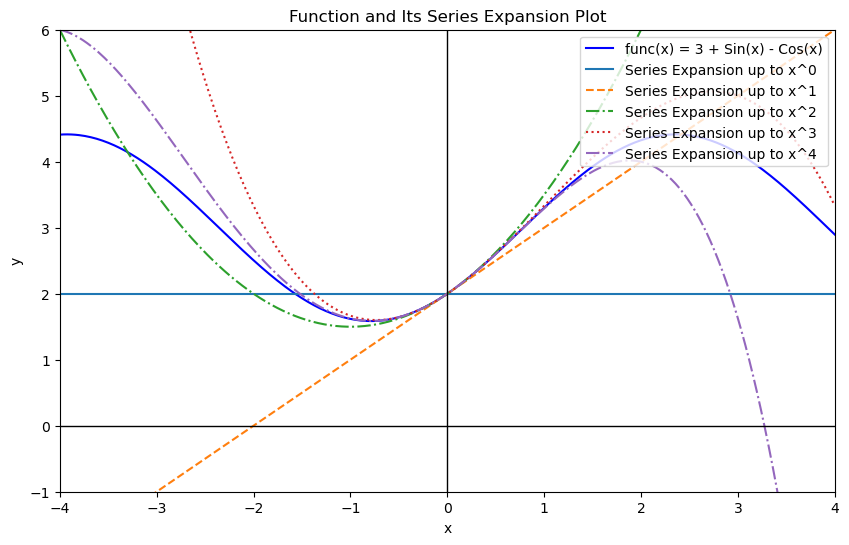

In [3]:
# Lambda function to convert SymPy expressions to NumPy functions
def sympy_to_numpy_function(sympy_func: sp.Expr, 
                            symbol: sp.Symbol
                           ) -> Callable[[np.ndarray], np.ndarray]:
    """
    Converts a SymPy function of a single variable to a NumPy-compatible function.
    
    Args:
        sympy_func: A SymPy expression representing the function.
        symbol: The SymPy symbol used in sympy_func.
    
    Returns:
        A lambda function that evaluates sympy_func over NumPy arrays.
    """
    return sp.lambdify(symbol, sympy_func, modules=['numpy'])

# Function to evaluate series expansions
def evaluate_expansion(expansion_func: Callable[[np.ndarray], np.ndarray], 
                       x_values: np.ndarray
                      ) -> np.ndarray:
    """
    Evaluates a given series expansion function for an array of x values.
    
    Args:
        expansion_func: A lambda function that takes x_values and evaluates the series expansion.
        x_values: A numpy array of x values at which to evaluate the expansion.
        
    Returns:
        A numpy array containing the evaluated series expansion at each x value.
    """
    # Evaluate the expansion for the provided x values
    result: np.ndarray = expansion_func(x_values)
    
    # Check if the result is a scalar and, if so, create an array filled with this value
    if np.isscalar(result):
        result = np.full_like(x_values, fill_value=result)
    
    return result

# Generate x values
x_values: np.ndarray = np.linspace(-4, 4, 400)

# Convert the main function to a numerical function and evaluate
func_lambdified: Callable[[np.ndarray], np.ndarray] = sympy_to_numpy_function(func, x)
y_values_func: np.ndarray = func_lambdified(x_values)

# Define line styles for different series expansions
line_styles: List[str] = ['-', '--', '-.', ':', 'dashdot']

# Plot the original function
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values_func, label='func(x) = 3 + Sin(x) - Cos(x)', color='blue', linestyle='-')

# Plot series expansions
n: int
style: str
for n, style in zip(range(5), line_styles):
    expansion_expr: sp.Expr = series_expansion(func, x, 0, n)
    expansion_lambdified: Callable[[np.ndarray], np.ndarray] = sympy_to_numpy_function(expansion_expr, x)
    y_values_expansion: np.ndarray = evaluate_expansion(expansion_lambdified, x_values)
    plt.plot(x_values, y_values_expansion, label=f'Series Expansion up to x^{n}', linestyle=style)

# Finalizing the plot
plt.title('Function and Its Series Expansion Plot')
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)  # Horizontal line for x-axis
plt.axvline(x=0, color='k', linestyle='-', linewidth=1)  # Vertical line for y-axis
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='upper right')
plt.xlim(-4, 4)
plt.ylim(-1, 6)
plt.show()


# Numpy code

## Deterministic solution (polynomial data)

In [4]:
from numpy.polynomial.polynomial import Polynomial

def y(x: np.ndarray) -> np.ndarray:
    """Generates polynomial data based on a given polynomial expression.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression.
    """
    return -x**4/24 - x**3/6 + x**2/2 + x + 2

def design_matrix(degree: int, 
                  x_values: np.ndarray
                 ) -> np.ndarray:
    """Generates a design matrix for polynomial regression of a specified degree.
    
    Args:
        degree: The degree of the polynomial hypothesis.
        x_values: A numpy array of x values.
    
    Returns:
        A design matrix as a numpy array.
    """
    return np.array([[x**i for i in range(degree+1)] for x in x_values])

def omega_solution(X: np.ndarray, 
                   Y: np.ndarray
                  ) -> np.ndarray:
    """Calculates the polynomial coefficients (omega) that best fit the data.
    
    Args:
        X: The design matrix.
        Y: A numpy array of target y values.
    
    Returns:
        A numpy array of calculated omega values.
    """
    return np.linalg.pinv(X.T @ X) @ X.T @ Y

def poly_solution(omega_solution: np.ndarray) -> Polynomial:
    """Converts omega coefficients to a numpy Polynomial object.
    
    Args:
        omega_solution: A numpy array of omega coefficients.
    
    Returns:
        A numpy Polynomial object representing the fitted polynomial.
    """
    return Polynomial(omega_solution)

def MSE(omega_solution: np.ndarray, 
        x_values: np.ndarray,
        y_true: np.ndarray
       ) -> float:
    """Calculates the Mean Squared Error (MSE) for given omega coefficients and x values.
    
    Args:
        omega_solution: A numpy array of omega coefficients.
        x_values: A numpy array of x values for evaluation.
        y_true: A numpy array of true y values.
    
    Returns:
        The MSE as a float.
    """
    poly: Polynomial = poly_solution(omega_solution)
    y_pred: np.ndarray = poly(x_values)
    return np.mean((y_true - y_pred)**2)

In [5]:
# Generate data coordinates
x_train: np.ndarray = np.arange(-3, 4, 1)
x_val: np.ndarray = np.arange(-2.5, 3.5, 1)

# Generate target values
y_train: np.ndarray = y(x_train)
y_val: np.ndarray = y(x_val)

print("Training Data:")
print(np.concatenate((x_train.reshape(-1, 1), y_train.reshape(-1, 1)), axis=1))

print("\nValidation Data:")
print(np.concatenate((x_val.reshape(-1, 1), y_val.reshape(-1, 1)), axis=1))

# Perform the fit for each degree and print the results
show: bool = True
for d in range(8):
    # Generate the design matrix
    X_train: np.ndarray = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: np.ndarray = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: Polynomial = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: float = MSE(omega_hat, x_train, y_train)
    MSE_val: float = MSE(omega_hat, x_val, y_val)
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")

Training Data:
[[-3.          4.625     ]
 [-2.          2.66666667]
 [-1.          1.625     ]
 [ 0.          2.        ]
 [ 1.          3.29166667]
 [ 2.          4.        ]
 [ 3.          1.625     ]]

Validation Data:
[[-2.5         3.6015625 ]
 [-1.5         1.9765625 ]
 [-0.5         1.64322917]
 [ 0.5         2.6015625 ]
 [ 1.5         3.8515625 ]
 [ 2.5         3.39322917]]
---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]

The solution for omega is: [2.83333333]

The polynomial is: 2.83333333

The MSE for the training data is: 1.2033730158730158
The MSE for the validation data is: 0.6907619900173613

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
[[ 1 -3]
 [ 1 -2]
 [ 1 -1]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]]

The solution for omega is: [ 2.83333333 -0.16666667]

The polynomial is: 2.83333333 - 0.16666667·x

The MSE for

## Deterministic solution (non-polynomial data)

In [6]:
def y(x: np.ndarray) -> np.ndarray:
    """Computes the function 3 + sin(x) - cos(x) for given x values.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the function.
    """
    return 3 + np.sin(x) - np.cos(x)

In [7]:
# Generate data coordinates
x_train: np.ndarray = np.arange(-3, 4, 1)
x_val: np.ndarray = np.arange(-2.5, 3.5, 1)

# Generate target values
y_train: np.ndarray = y(x_train)
y_val: np.ndarray = y(x_val)

print("Training Data:")
print(np.concatenate((x_train.reshape(-1, 1), y_train.reshape(-1, 1)), axis=1))

print("\nValidation Data:")
print(np.concatenate((x_val.reshape(-1, 1), y_val.reshape(-1, 1)), axis=1))

# Perform the fit for each degree and print the results
show: bool = True
for d in range(8):
    # Generate the design matrix
    X_train: np.ndarray = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: np.ndarray = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: Polynomial = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: float = MSE(omega_hat, x_train, y_train)
    MSE_val: float = MSE(omega_hat, x_val, y_val)
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")

Training Data:
[[-3.          3.84887249]
 [-2.          2.50684941]
 [-1.          1.61822671]
 [ 0.          2.        ]
 [ 1.          3.30116868]
 [ 2.          4.32544426]
 [ 3.          4.1311125 ]]

Validation Data:
[[-2.5         3.20267147]
 [-1.5         1.93176781]
 [-0.5         1.6429919 ]
 [ 0.5         2.60184298]
 [ 1.5         3.92675778]
 [ 2.5         4.39961576]]
---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]

The solution for omega is: [3.10452486]

The polynomial is: 3.10452486

The MSE for the training data is: 0.9890745526099051
The MSE for the validation data is: 1.0211811587186352

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
[[ 1 -3]
 [ 1 -2]
 [ 1 -1]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]]

The solution for omega is: [3.10452486 0.2202447 ]

The polynomial is: 3.10452486 + 0.2202447·x

The MSE for th

## Stochastic solution (polynomial data)

In [8]:
def y(x: np.ndarray) -> np.ndarray:
    """Generates polynomial data based on a given polynomial expression.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression.
    """
    return -x**4/24 - x**3/6 + x**2/2 + x + 2

def y_stat(x: np.ndarray) -> np.ndarray:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values: np.ndarray = y(x)
    
    # Add Gaussian noise with a mean of 0 and standard deviation of 1 to the true y values
    noisy_y_values: np.ndarray = np.random.normal(true_y_values, 1)
    
    return noisy_y_values

In [9]:
# Generate data coordinates
x_train: np.ndarray = np.arange(-3, 4, 1)
x_val: np.ndarray = np.arange(-2.5, 3.5, 1)

# Generate target values through the statistical model
np.random.seed(100)
y_train = y_stat(x_train)
y_val = y_stat(x_val)

print("Training Data:")
print(np.concatenate((x_train.reshape(-1, 1), y_train.reshape(-1, 1)), axis=1))

print("\nValidation Data:")
print(np.concatenate((x_val.reshape(-1, 1), y_val.reshape(-1, 1)), axis=1))

# Prepare a list to store solutions
solutions: List[Tuple[Any, np.ndarray, Callable[[np.ndarray], np.ndarray], float, float]] = []

# Perform the fit for each degree and print the results
show: bool = True
for d in range(10):
    # Generate the design matrix
    X_train: np.ndarray = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: np.ndarray = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: Polynomial = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: float = MSE(omega_hat, x_train, y_train)
    MSE_val: float = MSE(omega_hat, x_val, y_val)
    
    # Store the results
    solutions.append((d, omega_hat, poly, MSE_train, MSE_val))
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")
polynomial_fits = [sol[2] for sol in solutions]

Training Data:
[[-3.          2.87523453]
 [-2.          3.00934707]
 [-1.          2.7780358 ]
 [ 0.          1.74756396]
 [ 1.          4.27298745]
 [ 2.          4.51421884]
 [ 3.          1.84617967]]

Validation Data:
[[-2.5         2.53151917]
 [-1.5         1.78706667]
 [-0.5         1.89823061]
 [ 0.5         2.14353551]
 [ 1.5         4.28672599]
 [ 2.5         2.80963412]]
---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]

The solution for omega is: [3.0062239]

The polynomial is: 3.0062239

The MSE for the training data is: 0.9825576964383048
The MSE for the validation data is: 0.8936504124278191

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
[[ 1 -3]
 [ 1 -2]
 [ 1 -1]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]]

The solution for omega is: [3.0062239  0.05062609]

The polynomial is: 3.0062239 + 0.05062609·x

The MSE for the 

The polynomial is: 3.0062239 



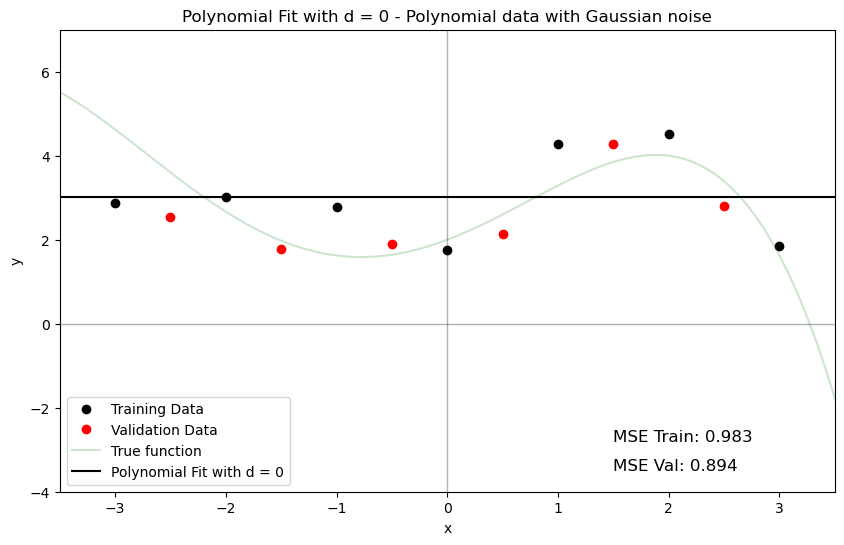

The polynomial is: 3.0062239 + 0.05062609·x 



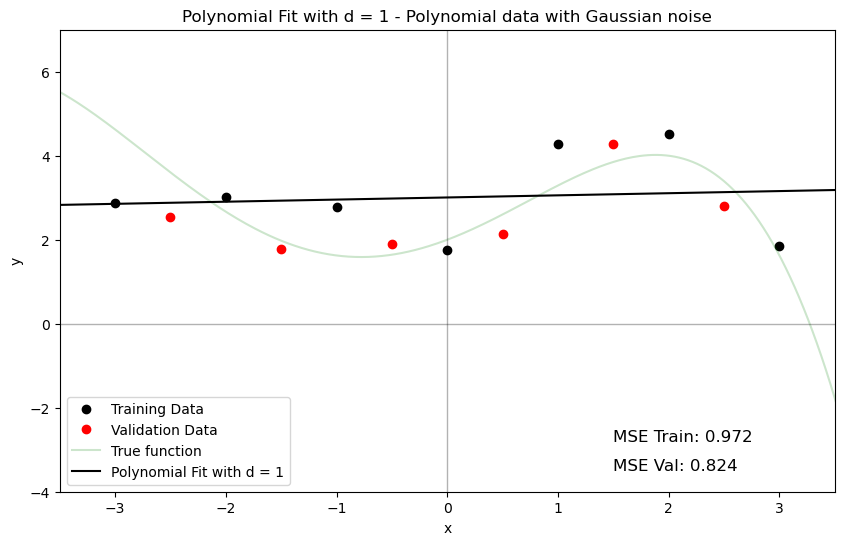

The polynomial is: 3.22223603 + 0.05062609·x - 0.05400303·x² 



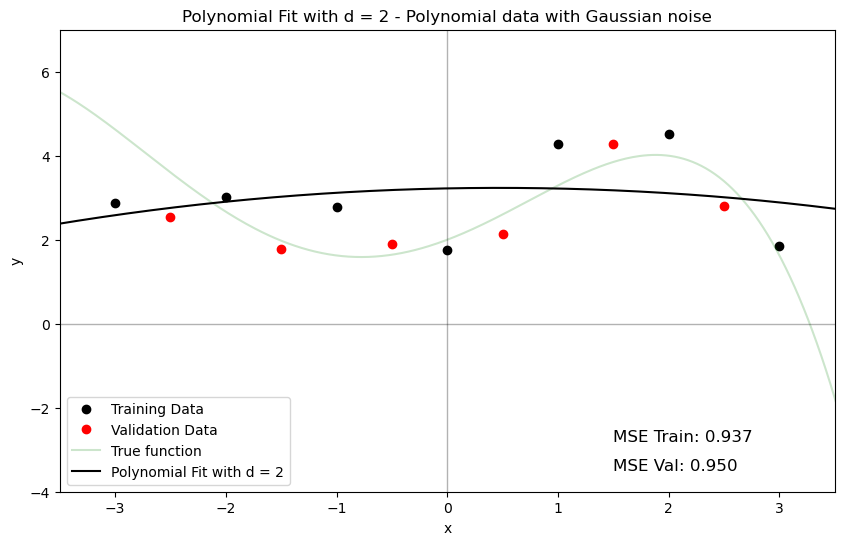

The polynomial is: 3.22223603 + 0.83401909·x - 0.05400303·x² - 0.11191329·x³ 



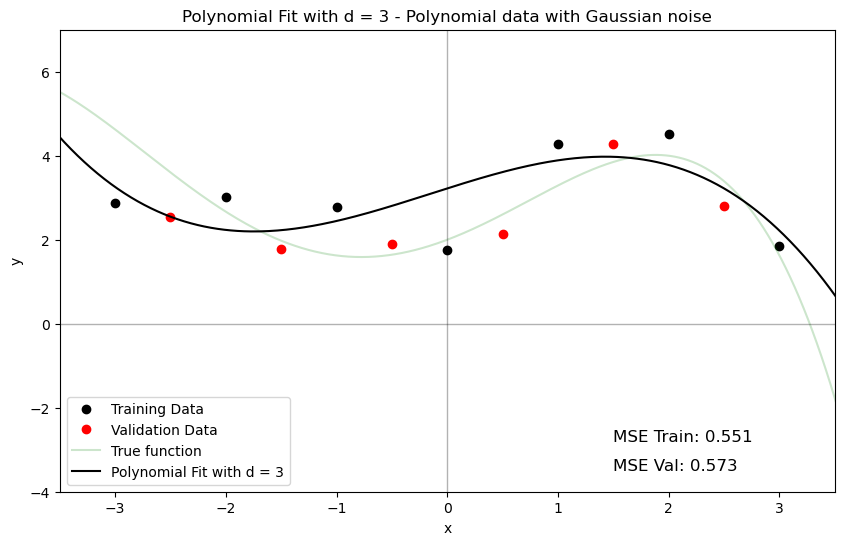

The polynomial is: 2.40544466 + 0.83401909·x + 0.70606671·x² - 0.11191329·x³ - 0.07941027·x⁴ 



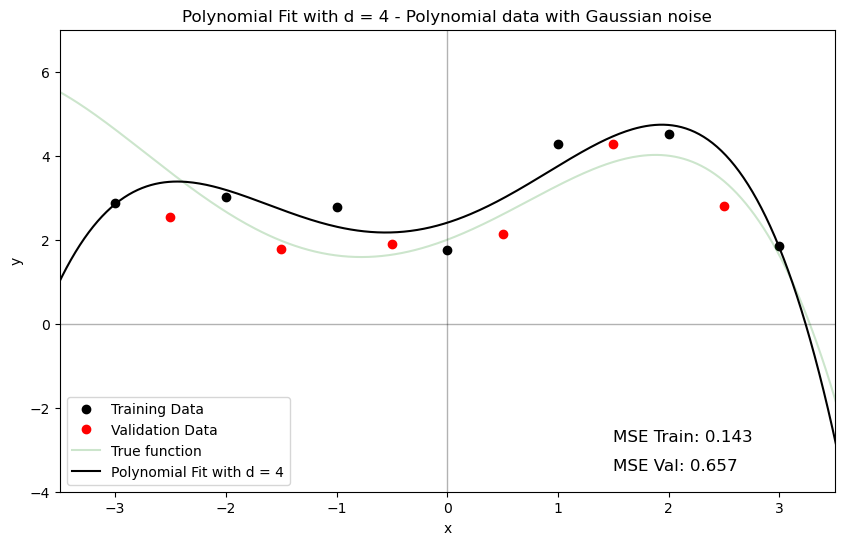

The polynomial is: 2.40544466 + 0.87833206·x + 0.70606671·x² - 0.13263213·x³ -
0.07941027·x⁴ + 0.0017759·x⁵ 



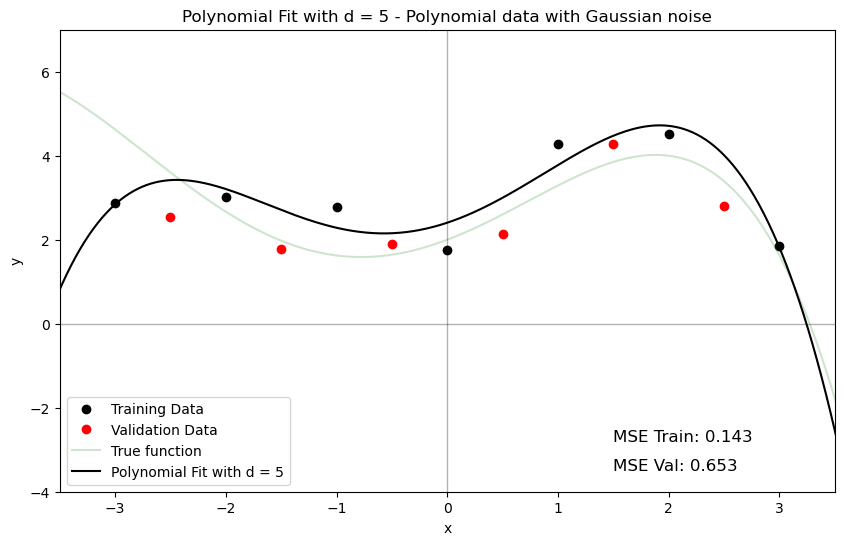

The polynomial is: 1.74756396 + 0.87833206·x + 2.37160135·x² - 0.13263213·x³ - 0.6358677·x⁴ +
0.0017759·x⁵ + 0.04221401·x⁶ 



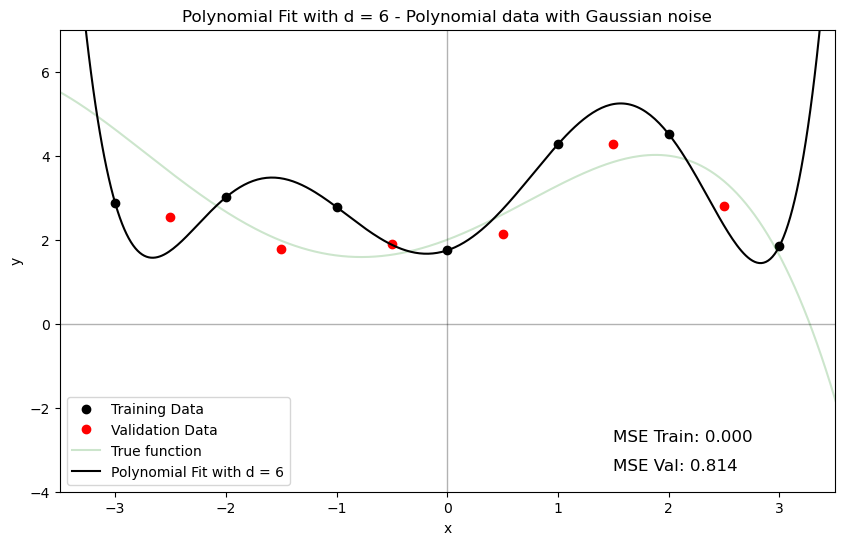

The polynomial is: 1.74756396 + 0.525693·x + 2.37160135·x² + 0.3473488·x³ - 0.6358677·x⁴ -
0.13536151·x⁵ + 0.04221401·x⁶ + 0.00979553·x⁷ 



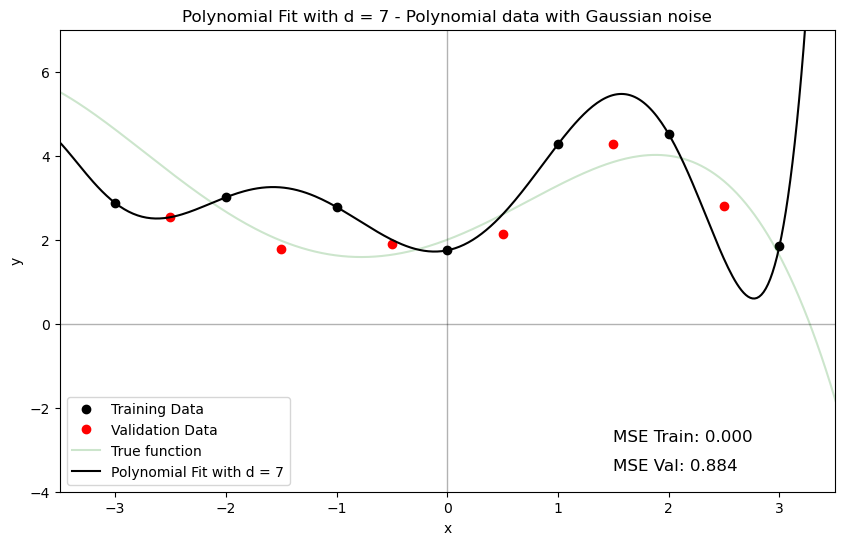

The polynomial is: 1.74756396 + 0.525693·x + 1.28877089·x² + 0.3473488·x³ + 0.83798488·x⁴ -
0.13536151·x⁵ - 0.37888672·x⁶ + 0.00979553·x⁷ + 0.03007862·x⁸ 



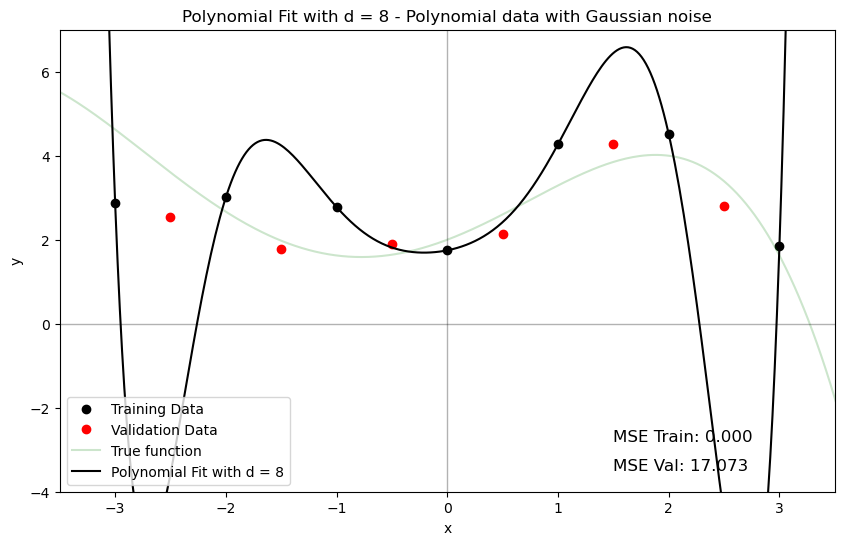

The polynomial is: 1.74756396 + 0.33764544·x + 1.28877089·x² + 0.30612012·x³ +
0.83798488·x⁴ + 0.19600702·x⁵ - 0.37888672·x⁶ - 0.10055182·x⁷ +
0.03007862·x⁸ + 0.00825506·x⁹ 



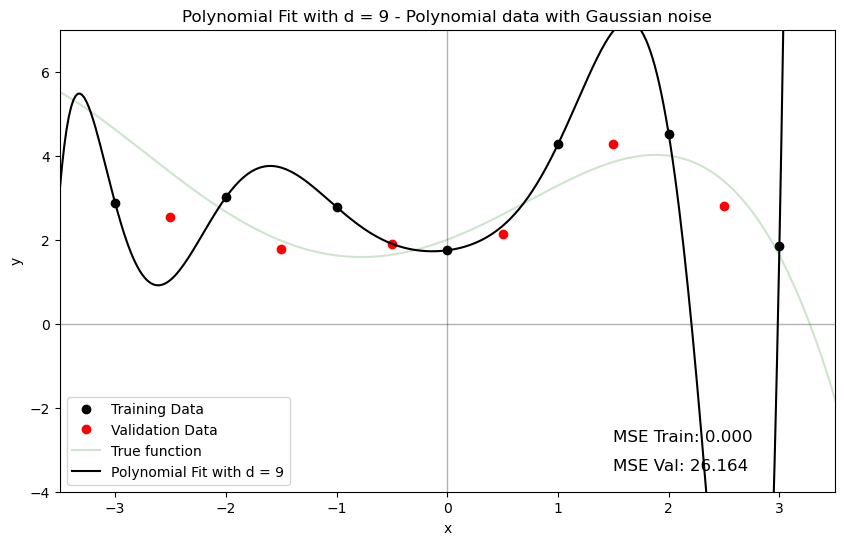

In [10]:
# Assuming polynomial_fits is a list of numpy.poly1d objects and solutions is a list of tuples containing the degree, 
# omega solutions, polynomial objects, MSE for training, and MSE for validation.

# Example preparation (ensure these are defined appropriately in your actual code)
# polynomial_fits = [np.poly1d(np.polyfit(x_train, y_train, d)) for d in range(8)]
# solutions = [(d, omega_hat, poly, MSE_train, MSE_val) for d, omega_hat, poly, MSE_train, MSE_val in ...]

def plot_polynomial_fits(x_train: np.ndarray, 
                         y_train: np.ndarray, 
                         x_val: np.ndarray, 
                         y_val: np.ndarray, 
                         polynomial_fits: List[np.poly1d], 
                         solutions: List[Tuple[int, np.ndarray, np.poly1d, float, float]],
                         dataset_name: str = "Dataset"
                        ) -> None:
    """Plots polynomial fits along with the training and validation data.
    
    Args:
        x_train: Training data x-values.
        y_train: Training data y-values.
        x_val: Validation data x-values.
        y_val: Validation data y-values.
        polynomial_fits: A list of polynomial fitting functions.
        solutions: A list of tuples containing information about each fit, including MSE for training and validation data.
    """
    for i in range(len(polynomial_fits)):
        print("The polynomial is:", polynomial_fits[i], "\n")
        plt.figure(figsize=(10, 6))
        plt.plot(x_train, y_train, 'o', label='Training Data', color='black')
        plt.plot(x_val, y_val, 'o', label='Validation Data', color='red')

        # Generate x values for plotting
        x_values: np.ndarray = np.linspace(-4, 4, 400)
        
        # Generate y values for the original function and its polynomial fit
        y_values_func: np.ndarray = y(x_values)
        y_values_fit: np.ndarray = polynomial_fits[i](x_values)

        # Display MSE values as text on the plot
        mse_train: float = solutions[i][3]
        mse_val: float = solutions[i][4]
        plt.text(1.5, -2.8, f'MSE Train: {mse_train:.3f}', fontsize=12, color='black')
        plt.text(1.5, -3.5, f'MSE Val: {mse_val:.3f}', fontsize=12, color='black')
        
        # Plot the function and polynomial fit
        plt.plot(x_values, y_values_func, label='True function', color='green', alpha=0.2)
        plt.plot(x_values, y_values_fit, label=f'Polynomial Fit with d = {i}', color='black')
        
        # Draw axes
        plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
        
        # Finalizing plot
        plt.title(f'Polynomial Fit with d = {i} - '+dataset_name)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(loc='lower left')
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4, 7)
        plt.show()

plot_polynomial_fits(x_train, y_train, x_val, y_val, polynomial_fits, solutions, "Polynomial data with Gaussian noise")


## Stochastic solution (non-polynomial data)

In [11]:
def y(x: np.ndarray) -> np.ndarray:
    """Generates polynomial data based on a given polynomial expression.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression.
    """
    return 3 + np.sin(x) - np.cos(x)

def y_stat(x: np.ndarray) -> np.ndarray:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values: np.ndarray = y(x)
    
    # Add Gaussian noise with a mean of 0 and standard deviation of 1 to the true y values
    noisy_y_values: np.ndarray = np.random.normal(true_y_values, 1)
    
    return noisy_y_values

In [12]:
# Generate data coordinates
x_train: np.ndarray = np.arange(-3, 4, 1)
x_val: np.ndarray = np.arange(-2.5, 3.5, 1)

# Generate target values through the statistical model
np.random.seed(100)
y_train = y_stat(x_train)
y_val = y_stat(x_val)

print("Training Data:")
print(np.concatenate((x_train.reshape(-1, 1), y_train.reshape(-1, 1)), axis=1))

print("\nValidation Data:")
print(np.concatenate((x_val.reshape(-1, 1), y_val.reshape(-1, 1)), axis=1))

# Prepare a list to store solutions
solutions: List[Tuple[Any, np.ndarray, Callable[[np.ndarray], np.ndarray], float, float]] = []

# Perform the fit for each degree and print the results
show: bool = True
for d in range(10):
    # Generate the design matrix
    X_train: np.ndarray = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: np.ndarray = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: Polynomial = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: float = MSE(omega_hat, x_train, y_train)
    MSE_val: float = MSE(omega_hat, x_val, y_val)
    
    # Store the results
    solutions.append((d, omega_hat, poly, MSE_train, MSE_val))
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")
polynomial_fits = [sol[2] for sol in solutions]

Training Data:
[[-3.          2.09910702]
 [-2.          2.84952981]
 [-1.          2.77126251]
 [ 0.          1.74756396]
 [ 1.          4.28248947]
 [ 2.          4.8396631 ]
 [ 3.          4.35229217]]

Validation Data:
[[-2.5         2.13262814]
 [-1.5         1.74227198]
 [-0.5         1.89799334]
 [ 0.5         2.14381599]
 [ 1.5         4.36192127]
 [ 2.5         3.81602071]]
---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]

The solution for omega is: [3.27741544]

The polynomial is: 3.27741544

The MSE for the training data is: 1.2534692480735976
The MSE for the validation data is: 1.3868841559961655

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
[[ 1 -3]
 [ 1 -2]
 [ 1 -1]
 [ 1  0]
 [ 1  1]
 [ 1  2]
 [ 1  3]]

The solution for omega is: [3.27741544 0.43753746]

The polynomial is: 3.27741544 + 0.43753746·x

The MSE for t

The polynomial is: 3.27741544 



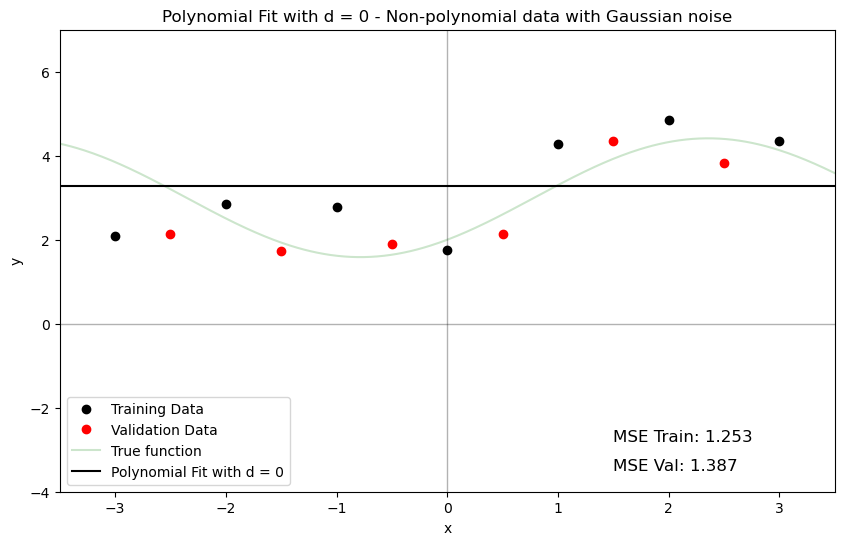

The polynomial is: 3.27741544 + 0.43753746·x 



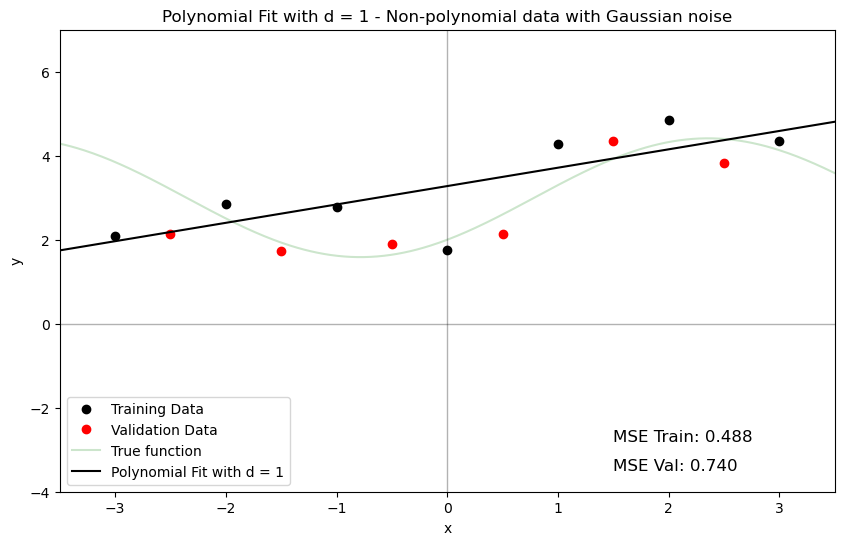

The polynomial is: 3.08191619 + 0.43753746·x + 0.04887481·x² 



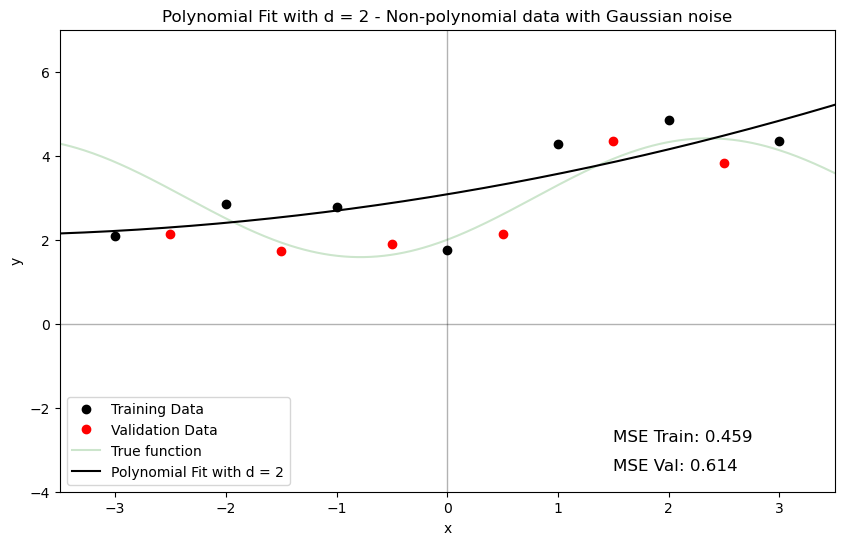

The polynomial is: 3.08191619 + 0.68023818·x + 0.04887481·x² - 0.03467153·x³ 



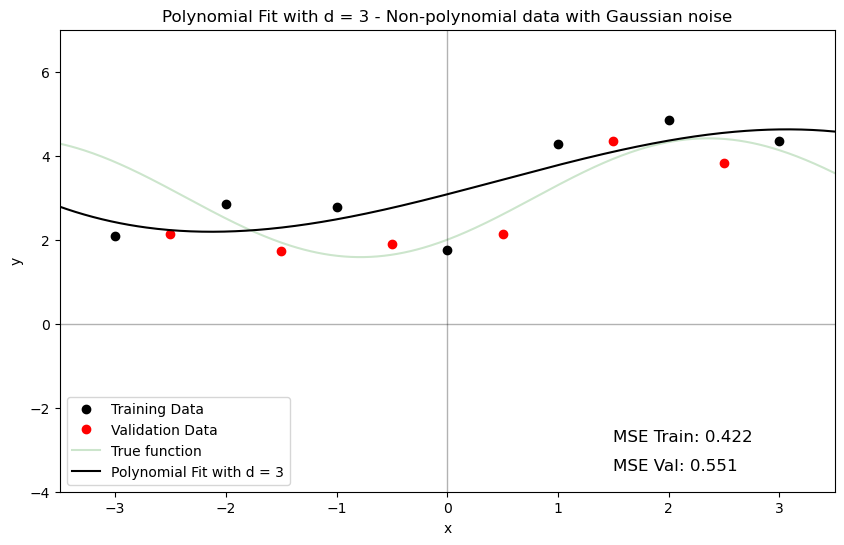

The polynomial is: 2.42226617 + 0.68023818·x + 0.6627158·x² - 0.03467153·x³ - 0.06413264·x⁴ 



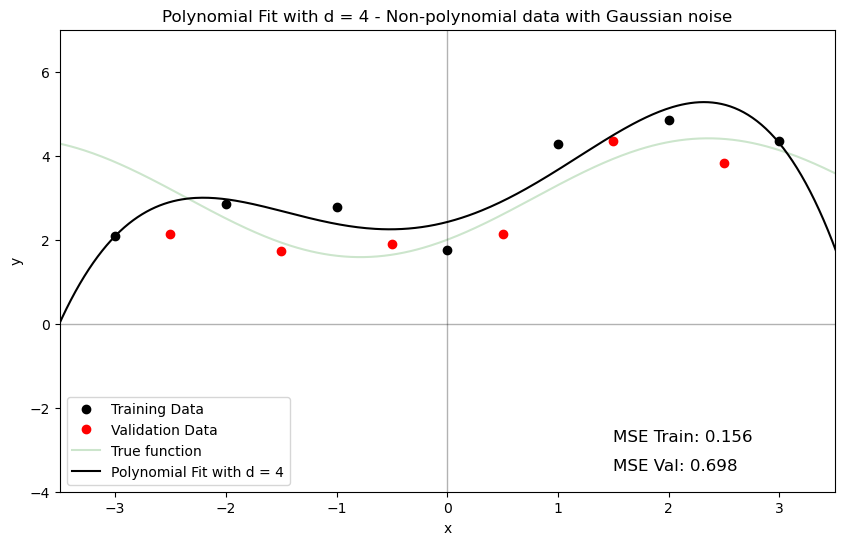

The polynomial is: 2.42226617 + 0.87245331·x + 0.6627158·x² - 0.12454311·x³ - 0.06413264·x⁴ +
0.00770328·x⁵ 



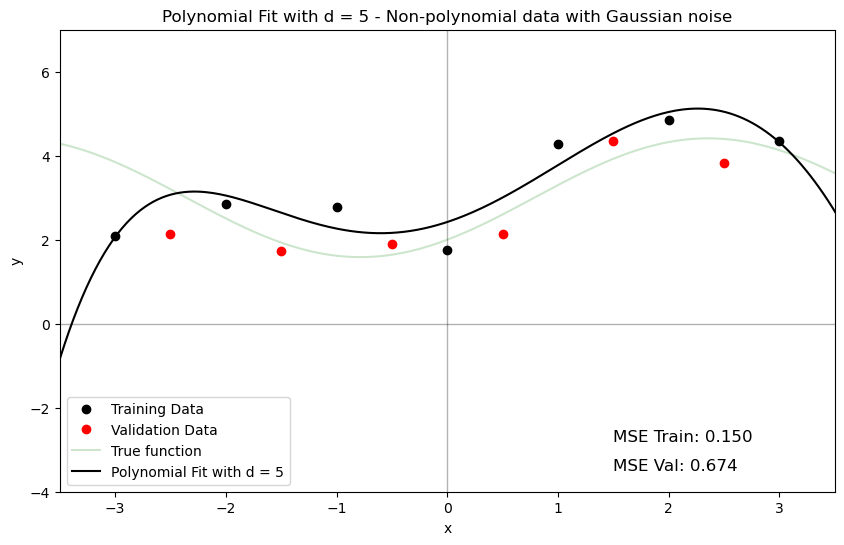

The polynomial is: 1.74756396 + 0.87245331·x + 2.37083689·x² - 0.12454311·x³ -
0.63481826·x⁴ + 0.00770328·x⁵ + 0.04329339·x⁶ 



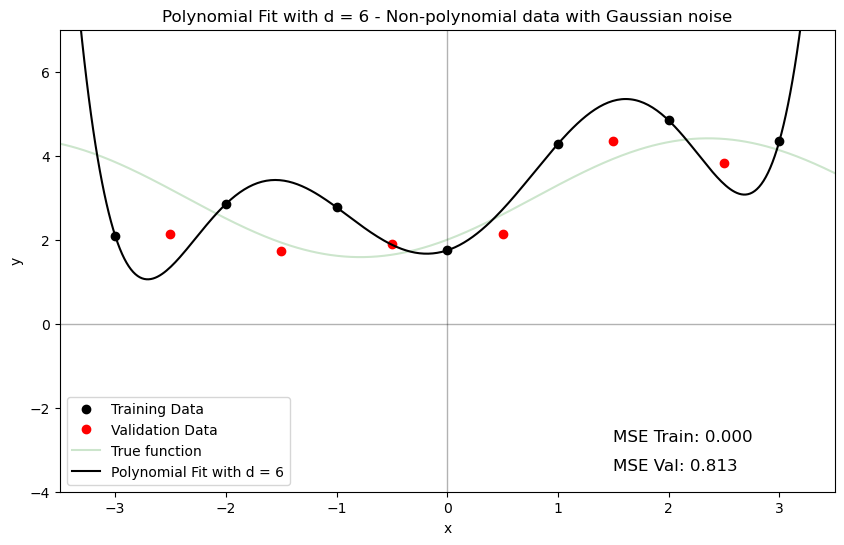

The polynomial is: 1.74756396 + 0.524668·x + 2.37083689·x² + 0.34883134·x³ - 0.63481826·x⁴ -
0.12754656·x⁵ + 0.04329339·x⁶ + 0.0096607·x⁷ 



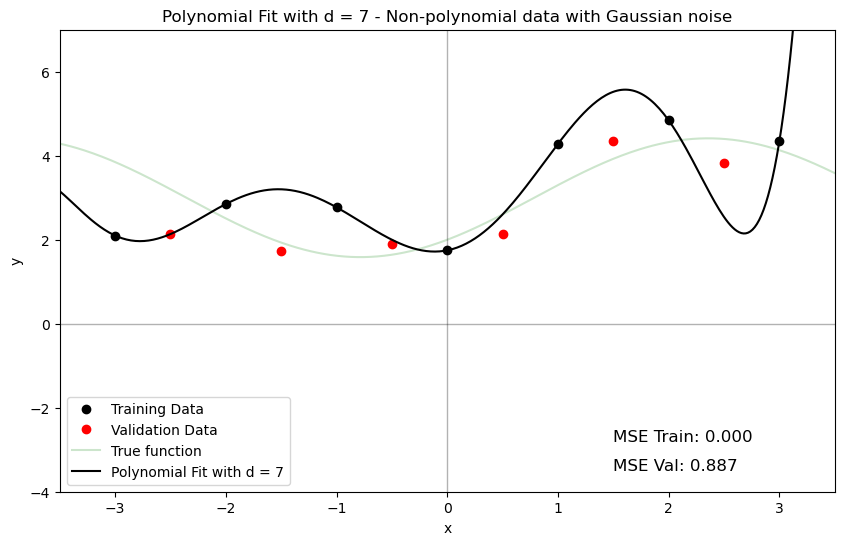

The polynomial is: 1.74756396 + 0.524668·x + 1.28859655·x² + 0.34883134·x³ + 0.8382311·x⁴ -
0.12754656·x⁵ - 0.37757785·x⁶ + 0.0096607·x⁷ + 0.03006223·x⁸ 



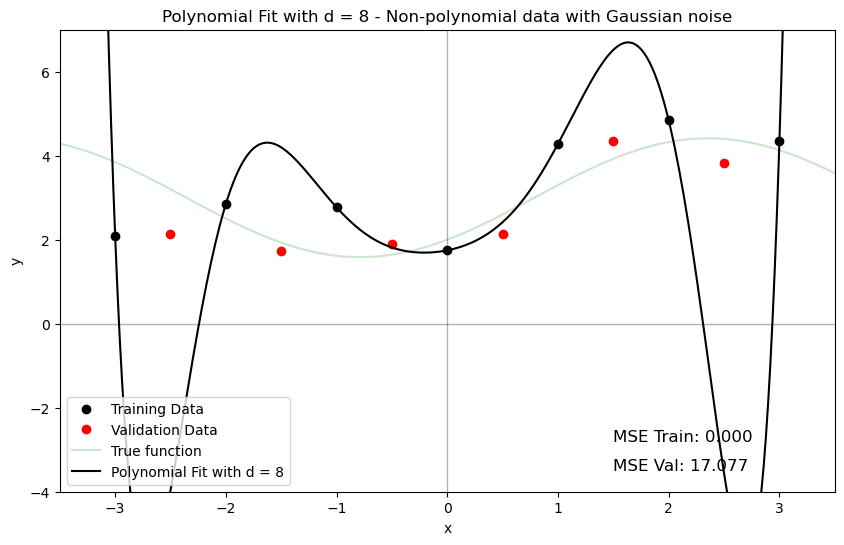

The polynomial is: 1.74756396 + 0.33985417·x + 1.28859655·x² + 0.30831164·x³ + 0.8382311·x⁴ +
0.19812365·x⁵ - 0.37757785·x⁶ - 0.09878908·x⁷ + 0.03006223·x⁸ +
0.00811311·x⁹ 



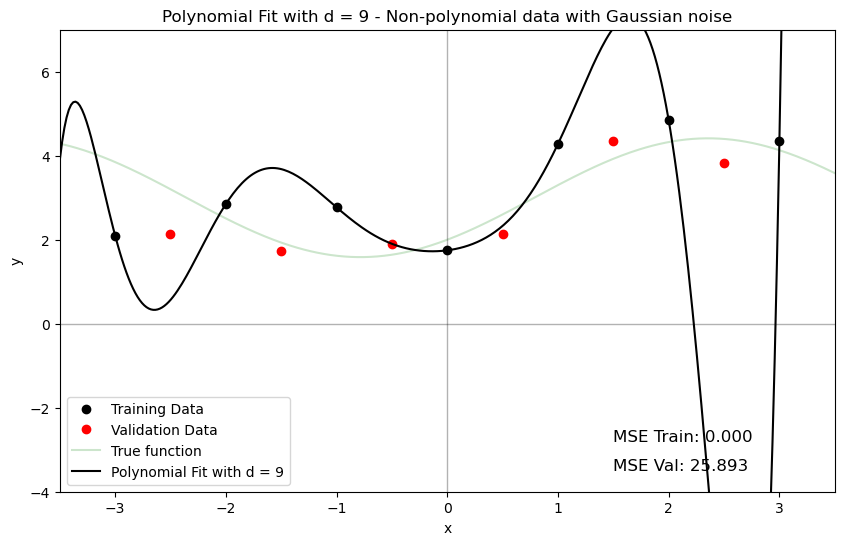

In [13]:
plot_polynomial_fits(x_train, y_train, x_val, y_val, polynomial_fits, solutions, "Non-polynomial data with Gaussian noise")

## Stochastic solution with non-polynomial fit (non-polynomial data)

In [14]:
def y(x: np.ndarray) -> np.ndarray:
    """Generates polynomial data based on a given polynomial expression.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression.
    """
    return 3 + np.sin(x) - np.cos(x)

def y_stat(x: np.ndarray) -> np.ndarray:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values: np.ndarray = y(x)
    
    # Add Gaussian noise with a mean of 0 and standard deviation of 1 to the true y values
    noisy_y_values: np.ndarray = np.random.normal(true_y_values, 1)
    
    return noisy_y_values

def design_matrix_trig(x_values: np.ndarray) -> np.ndarray:
    """Generates a design matrix for trigonometric regression.
    
    Args:
        x_values: A numpy array of x values.
    
    Returns:
        A design matrix as a numpy array with columns for 1, sin(x), and cos(x).
    """
    # The design matrix includes columns for the constant term, sin(x), and cos(x)
    return np.column_stack((np.ones_like(x_values), np.sin(x_values), np.cos(x_values)))

def omega_solution(X: np.ndarray, 
                   Y: np.ndarray
                  ) -> np.ndarray:
    """Calculates the coefficients (omega) that best fit the data for a given design matrix.
    
    Args:
        X: The design matrix.
        Y: A numpy array of target y values.
    
    Returns:
        A numpy array of calculated omega values.
    """
    return np.linalg.pinv(X.T @ X) @ X.T @ Y

def trig_solution(omega_solution: np.ndarray, 
                  x_values: np.ndarray
                 ) -> np.ndarray:
    """Evaluates the trigonometric model at given x values using the omega coefficients.
    
    Args:
        omega_solution: A numpy array of omega coefficients for [constant, sin(x), cos(x)].
        x_values: A numpy array of x values for evaluation.
    
    Returns:
        A numpy array of y values predicted by the trigonometric model.
    """
    return omega_solution[0] + omega_solution[1] * np.sin(x_values) + omega_solution[2] * np.cos(x_values)

def MSE(omega_solution: np.ndarray, 
        x_values: np.ndarray,
        y_true: np.ndarray
       ) -> float:
    """Calculates the Mean Squared Error (MSE) for given omega coefficients and x values.
    
    Args:
        omega_solution: A numpy array of omega coefficients.
        x_values: A numpy array of x values for evaluation.
        y_true: A numpy array of true y values.
    
    Returns:
        The MSE as a float.
    """
    y_pred = trig_solution(omega_solution, x_values)
    return np.mean((y_true - y_pred)**2)


In [15]:
# Generate data coordinates
x_train: np.ndarray = np.arange(-3, 4, 1)
x_val: np.ndarray = np.arange(-2.5, 3.5, 1)

# Generate target values through the statistical model
np.random.seed(100)
y_train: np.ndarray = y_stat(x_train)
y_val: np.ndarray = y_stat(x_val)

# Flag to control printing of the solution details
show: bool = True

# Generate the design matrix
X_train: np.ndarray = design_matrix_trig(x_train)

# Compute the weights of the solution
omega_hat: np.ndarray = omega_solution(X_train, y_train)

# Compute the MSE for the training and validation data
MSE_train: float = MSE(omega_hat, x_train, y_train)
MSE_val: float = MSE(omega_hat, x_val, y_val)

# Print the results
if show:
    print("----------------- Trigonometric Model -----------------")
    print(f"The design matrix is:\n{X_train}\n")
    print(f"The target values are:\n{y_train}\n")
    print(f"The solution for omega is: {omega_hat}\n")
    print(f"The MSE for the training data is: {MSE_train}")
    print(f"The MSE for the validation data is: {MSE_val}\n")

----------------- Trigonometric Model -----------------
The design matrix is:
[[ 1.         -0.14112001 -0.9899925 ]
 [ 1.         -0.90929743 -0.41614684]
 [ 1.         -0.84147098  0.54030231]
 [ 1.          0.          1.        ]
 [ 1.          0.84147098  0.54030231]
 [ 1.          0.90929743 -0.41614684]
 [ 1.          0.14112001 -0.9899925 ]]

The target values are:
[2.09910702 2.84952981 2.77126251 1.74756396 4.28248947 4.8396631
 4.35229217]

The solution for omega is: [ 3.23274463  1.09313872 -0.42737018]

The MSE for the training data is: 0.6231208529025826
The MSE for the validation data is: 0.44267908415881113



Fit with true function



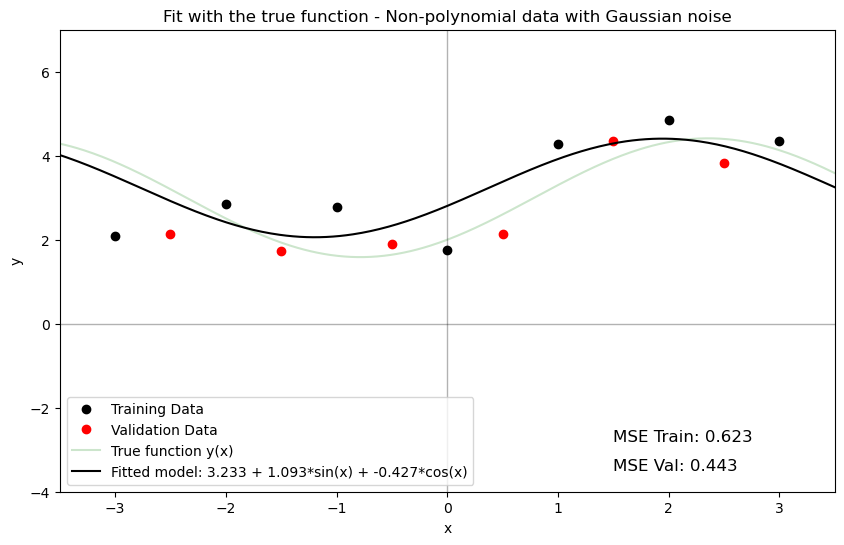

In [16]:
print("Fit with true function\n")
omega_hat_str = f"{omega_hat[0]:.3f} + {omega_hat[1]:.3f}*sin(x) + {omega_hat[2]:.3f}*cos(x)"
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, 'o', label='Training Data', color='black')
plt.plot(x_val, y_val, 'o', label='Validation Data', color='red')

# Generate x values for plotting
x_values = np.linspace(-4, 4, 400)

# Generate y values for the function and the model fit
y_values_func = y(x_values)
y_values_fit = trig_solution(omega_hat, x_values)  # Use trig_solution instead of poly_solution

plt.text(1.5, -2.8, f'MSE Train: {MSE_train:.3f}', fontsize=12, color='black')
plt.text(1.5, -3.5, f'MSE Val: {MSE_val:.3f}', fontsize=12, color='black')
    
plt.plot(x_values, y_values_func, label='True function y(x)', color='green', alpha=0.2)
plt.plot(x_values, y_values_fit, label='Fitted model: ' + omega_hat_str, color='black')

# Drawing axes
plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.3)

# Finalizing plot
plt.title(f'Fit with the true function - Non-polynomial data with Gaussian noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower left')
plt.xlim(-3.5, 3.5)
plt.ylim(-4, 7)
plt.show()


# TensorFlow2 code

## Deterministic solution (polynomial data)

In [17]:
class PolynomialTF:
    def __init__(self, coefficients):
        """
        Initializes the polynomial with given coefficients.

        Args:
            coefficients: A 1D tf.Tensor or a Python list of polynomial coefficients
                          from the lowest to the highest degree.
        """
        self.coefficients = tf.convert_to_tensor(coefficients, dtype=tf.float64)

    def __call__(self, x):
        """
        Evaluates the polynomial at given x values.

        Args:
            x: A 1D tf.Tensor of x values where the polynomial is to be evaluated.

        Returns:
            A tf.Tensor containing the evaluated polynomial values at each x value.
        """
        x = tf.convert_to_tensor(x, dtype=tf.float64)
        degree = tf.shape(self.coefficients)[0]
        x_powers = tf.pow(tf.expand_dims(x, -1), tf.range(0, degree, dtype=tf.float64))
        poly_values = tf.reduce_sum(tf.multiply(x_powers, self.coefficients), axis=1)
        return poly_values

    def __str__(self):
        """
        Returns a string representation of the polynomial.
        """
        terms = []
        for i, coeff in enumerate(self.coefficients.numpy()):
            if coeff != 0:  # Skip terms with a coefficient of zero
                if i == 0:
                    terms.append(f"{coeff:.10g}")
                elif i == 1:
                    terms.append(f"{coeff:+.10g} x")
                else:
                    terms.append(f"{coeff:+.10g} x**{i}")
        return " ".join(terms)


In [18]:
def y(x: tf.Tensor) -> tf.Tensor:
    """Generates polynomial data based on a given polynomial expression.
    
    Args:
        x: A tf tensor of x values.
    
    Returns:
        A tf tensor of y values computed from the polynomial expression.
    """
    return tf.cast(-tf.pow(x, 4)/24 - tf.pow(x, 3)/6 + tf.pow(x, 2)/2 + x + 2, dtype=tf.float64)

def design_matrix(degree: int,
                  x_values: tf.Tensor
                 ) -> tf.Tensor:
    """Generates a design matrix for polynomial regression of a specified degree.
    
    Args:
        degree: The degree of the polynomial hypothesis.
        x_values: A tf tensor of x values.
    
    Returns:
        A design matrix as a tf tensor.
    """
    return tf.stack([x_values**i for i in range(degree + 1)], axis=1)

def omega_solution(X: tf.Tensor, 
                   Y: tf.Tensor
                  ) -> tf.Tensor:
    """Calculates the polynomial coefficients (omega) that best fit the data.
    
    Args:
        X: The design matrix.
        Y: A tf tensor of target y values.
    
    Returns:
        A tf tensor of calculated omega values.
    """
    XT: tf.Tensor = tf.transpose(X)
    Y: tf.Tensor = tf.reshape(Y, (-1, 1))
    omega: tf.Tensor = tf.linalg.pinv(XT @ X) @ XT @ Y
    return tf.reshape(omega, [-1])

def poly_solution(omega_solution: tf.Tensor) -> PolynomialTF:
    """Converts omega coefficients to a tf PolynomialTF object.
    
    Args:
        omega_solution: A tf.Tensor of omega coefficients.
    
    Returns:
        A tf PolynomialTF object representing the fitted polynomial.
    """
    return PolynomialTF(omega_solution)

def MSE(omega_solution: tf.Tensor, 
        x_values: tf.Tensor,
        y_true: tf.Tensor
       ) -> tf.Tensor:
    """Calculates the Mean Squared Error (MSE) for given omega coefficients and x values.
    
    Args:
        omega_solution: A 1D tf.Tensor of omega coefficients.
        x_values: A 1D tf.Tensor of x values for evaluation.
        y_true: A 1D tf.Tensor of true y values.
    
    Returns:
        The MSE as a tf.Tensor.
    """
    poly: PolynomialTF = poly_solution(omega_solution)
    y_pred: tf.Tensor = poly(x_values)
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [19]:
# Generate data coordinates
x_train: tf.Tensor = tf.range(-3, 4, 1, dtype=tf.float64)
x_val: tf.Tensor = tf.range(-2.5, 3.5, 1, dtype=tf.float64)

# Generate target values
y_train: tf.Tensor = y(x_train)
y_val: tf.Tensor = y(x_val)

# Perform the fit for each degree and print the results
show: bool = True
for d in range(8):
    # Generate the design matrix
    X_train: tf.Tensor = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: tf.Tensor = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: PolynomialTF = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: tf.Tensor = MSE(omega_hat, x_train, y_train)
    MSE_val: tf.Tensor = MSE(omega_hat, x_val, y_val)
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")

---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

The solution for omega is: [2.83333333]

The polynomial is: 2.833333333

The MSE for the training data is: 1.2033730158730158
The MSE for the validation data is: 0.6907619900173613

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
[[ 1. -3.]
 [ 1. -2.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]]

The solution for omega is: [ 2.83333333 -0.16666667]

The polynomial is: 2.833333333 -0.1666666667 x

The MSE for the training data is: 1.0922619047619049
The MSE for the validation data is: 0.925715693721065

---------------------- d = 2 ----------------------
The degree of the polynomial is: 2

The design matrix is:
[[ 1. -3.  9.]
 [ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]]

The solution for omega is: [ 2.42857143 -0.16666

2025-02-27 16:33:10.193577: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Deterministic solution (non-polynomial data)

In [20]:
def y(x: tf.Tensor) -> tf.Tensor:
    """Computes the function 3 + sin(x) - cos(x) for given x values.
    
    Args:
        x: A tf tensor of x values.
    
    Returns:
        A tf tensor of y values computed from the function.
    """
    return 3. + tf.sin(x) - tf.cos(x)

In [21]:
# Generate data coordinates
x_train: tf.Tensor = tf.range(-3, 4, 1, dtype=tf.float64)
x_val: tf.Tensor = tf.range(-2.5, 3.5, 1, dtype=tf.float64)

# Generate target values
y_train: tf.Tensor = y(x_train)
y_val: tf.Tensor = y(x_val)

# Perform the fit for each degree and print the results
show: bool = True
for d in range(10):
    # Generate the design matrix
    X_train: tf.Tensor = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: tf.Tensor = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: PolynomialTF = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: tf.Tensor = MSE(omega_hat, x_train, y_train)
    MSE_val: tf.Tensor = MSE(omega_hat, x_val, y_val)
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        #print(f"The hypothesis is: {poly}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")

---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

The solution for omega is: [3.10452486]

The polynomial is: 3.104524865

The MSE for the training data is: 0.9890745526099051
The MSE for the validation data is: 1.0211811587186352

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
[[ 1. -3.]
 [ 1. -2.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]]

The solution for omega is: [3.10452486 0.2202447 ]

The polynomial is: 3.104524865 +0.2202447045 x

The MSE for the training data is: 0.7950436332141865
The MSE for the validation data is: 0.6880882026927809

---------------------- d = 2 ----------------------
The degree of the polynomial is: 2

The design matrix is:
[[ 1. -3.  9.]
 [ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]]

The solution for omega is: [2.28825159 0.2202447 

## Stochastic solution (polynomial data)

In [22]:
def y(x: tf.Tensor) -> tf.Tensor:
    """Generates polynomial data based on a given polynomial expression.
    
    Args:
        x: A tf tensor of x values.
    
    Returns:
        A tf tensor of y values computed from the polynomial expression.
    """
    return tf.cast(-tf.pow(x, 4)/24 - tf.pow(x, 3)/6 + tf.pow(x, 2)/2 + x + 2, dtype=tf.float64)
    
def y_stat(x: tf.Tensor) -> tf.Tensor:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.
    
    Args:
        x: A tf tensor of x values.
    
    Returns:
        A tf tensor of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values: tf.Tensor = y(x)
    
    # Add Gaussian noise with a mean of 0 and standard deviation of 1 to the true y values
    noisy_y_values: tf.Tensor = true_y_values + tf.random.normal(tf.shape(true_y_values), mean=0.0, stddev=1.0, dtype=tf.float64)
    
    return noisy_y_values

In [23]:
# Generate data coordinates
x_train: tf.Tensor = tf.range(-3, 4, 1, dtype=tf.float64)
x_val: tf.Tensor = tf.range(-2.5, 3.5, 1, dtype=tf.float64)

# Generate target values
tf.random.set_seed(100)
y_train: tf.Tensor = y_stat(x_train)
y_val: tf.Tensor = y_stat(x_val)

# Prepare a list to store solutions
solutions: List[Tuple[Any, tf.Tensor, PolynomialTF, tf.Tensor, tf.Tensor]] = []

# Perform the fit for each degree and print the results
show: bool = True
for d in range(10):
    # Generate the design matrix
    X_train: tf.Tensor = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: tf.Tensor = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: PolynomialTF = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: tf.Tensor = MSE(omega_hat, x_train, y_train)
    MSE_val: tf.Tensor = MSE(omega_hat, x_val, y_val)
    
    # Store the results
    solutions.append((d, omega_hat, poly, MSE_train, MSE_val))
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        #print(f"The hypothesis is: {poly}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")
polynomial_fits = [sol[2] for sol in solutions]

---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

The solution for omega is: [3.11523274]

The polynomial is: 3.115232744

The MSE for the training data is: 1.7700305520833184
The MSE for the validation data is: 0.9464090512998898

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
[[ 1. -3.]
 [ 1. -2.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]]

The solution for omega is: [3.11523274 0.10150679]

The polynomial is: 3.115232744 +0.1015067909 x

The MSE for the training data is: 1.7288160376530215
The MSE for the validation data is: 0.8718905749612729

---------------------- d = 2 ----------------------
The degree of the polynomial is: 2

The design matrix is:
[[ 1. -3.  9.]
 [ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]]

The solution for omega is: [2.01883045 0.10150679

The polynomial is: 3.115232744 



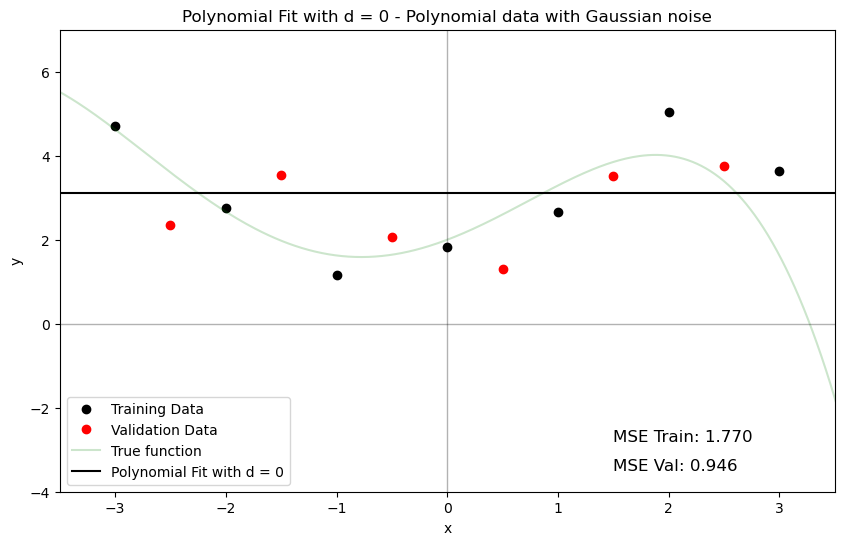

The polynomial is: 3.115232744 +0.1015067909 x 



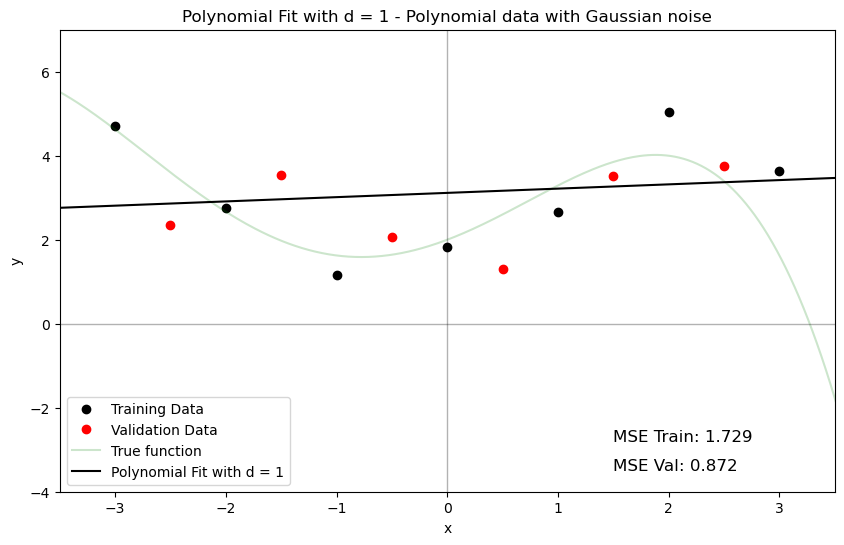

The polynomial is: 2.018830449 +0.1015067909 x +0.2741005737 x**2 



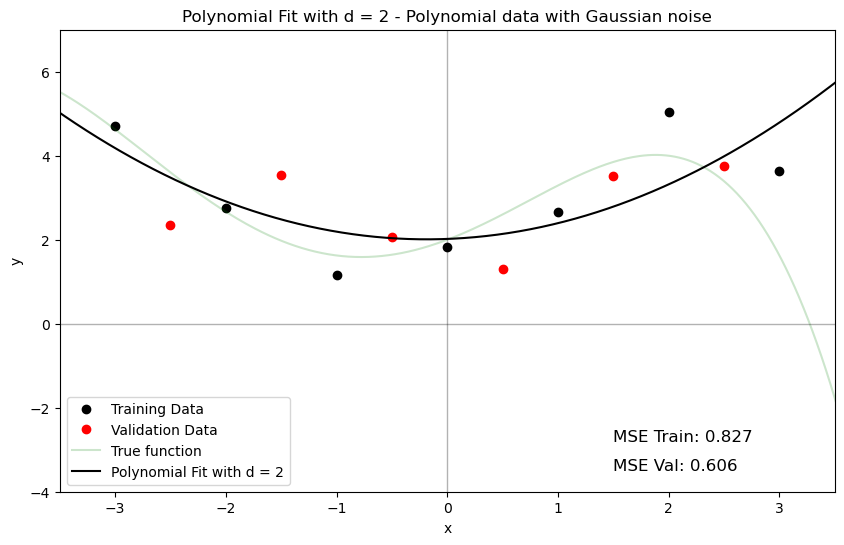

The polynomial is: 2.018830449 +1.047080437 x +0.2741005737 x**2 -0.1350819495 x**3 



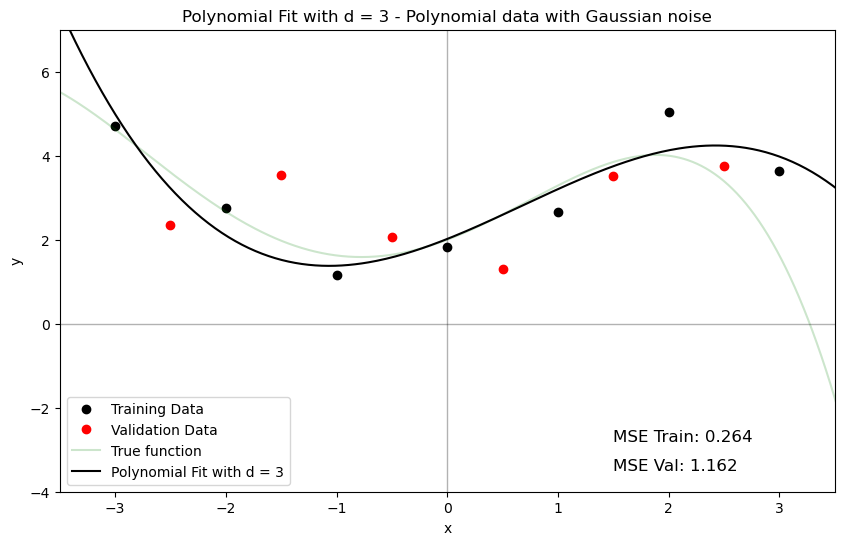

The polynomial is: 1.444079113 +1.047080437 x +0.808938623 x**2 -0.1350819495 x**3 -0.05587860217 x**4 



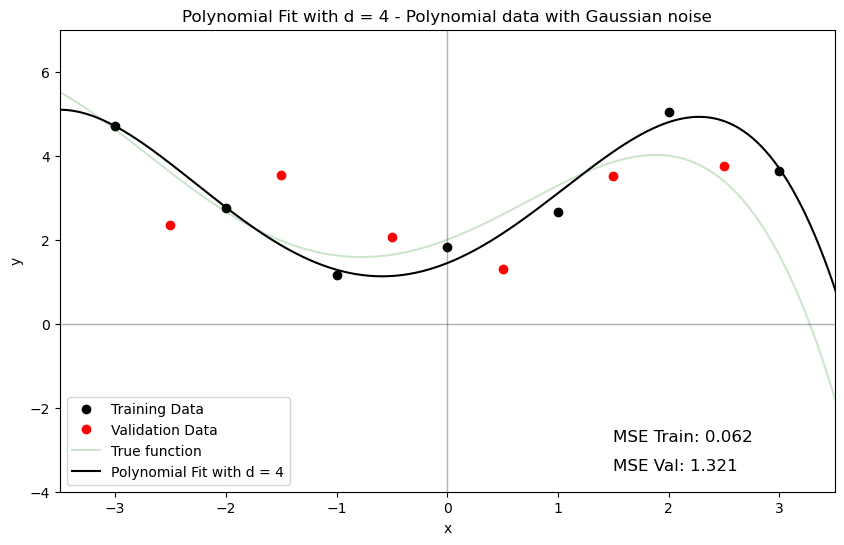

The polynomial is: 1.444079113 +0.7506805564 x +0.808938623 x**2 +0.003501964342 x**3 -0.05587860217 x**4 -0.01187862119 x**5 



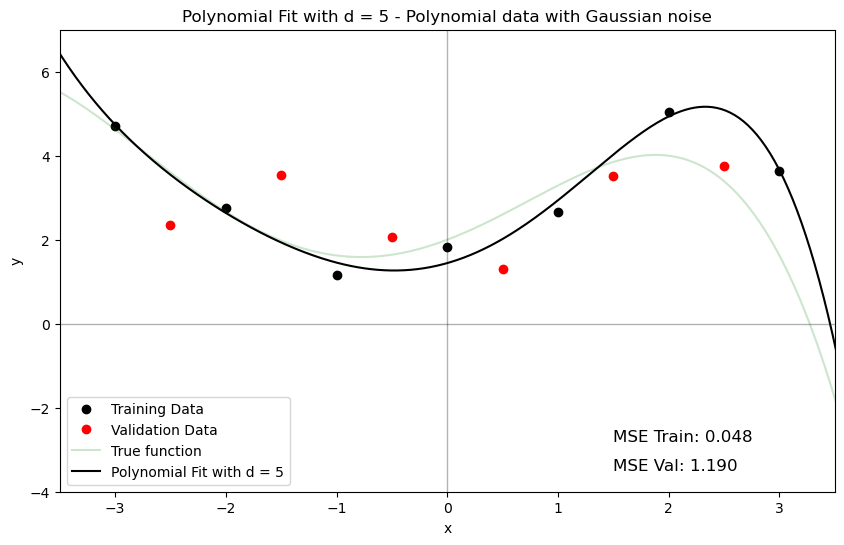

The polynomial is: 1.827413987 +0.7506805564 x -0.1615374988 x**2 +0.003501964342 x**3 +0.2683588118 x**4 -0.01187862119 x**5 -0.02459732106 x**6 



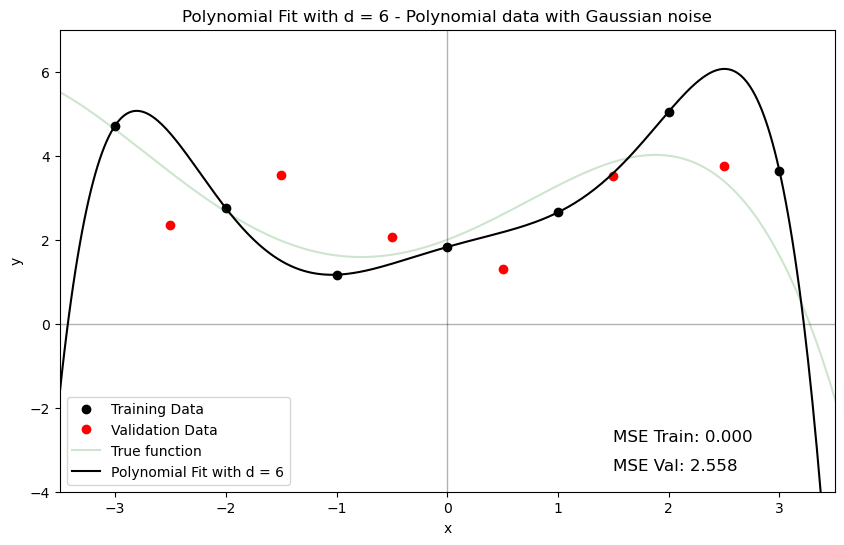

The polynomial is: 1.827413987 +0.5039631165 x -0.1615374988 x**2 +0.3393118131 x**3 +0.2683588118 x**4 -0.1078242923 x**5 -0.02459732106 x**6 +0.006853262219 x**7 



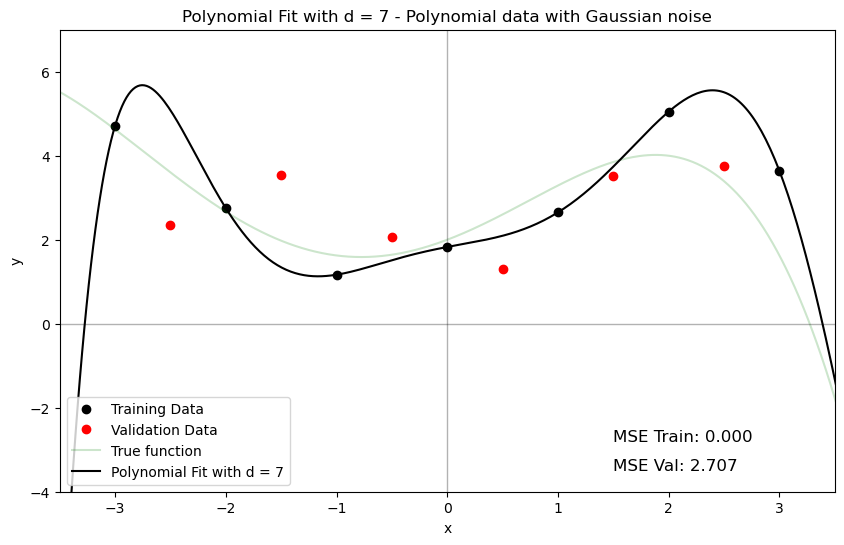

The polynomial is: 1.827413987 +0.5039631165 x +0.01697677758 x**2 +0.3393118131 x**3 +0.02538104673 x**4 -0.1078242923 x**5 +0.04482489753 x**6 +0.006853262219 x**7 -0.004958729899 x**8 



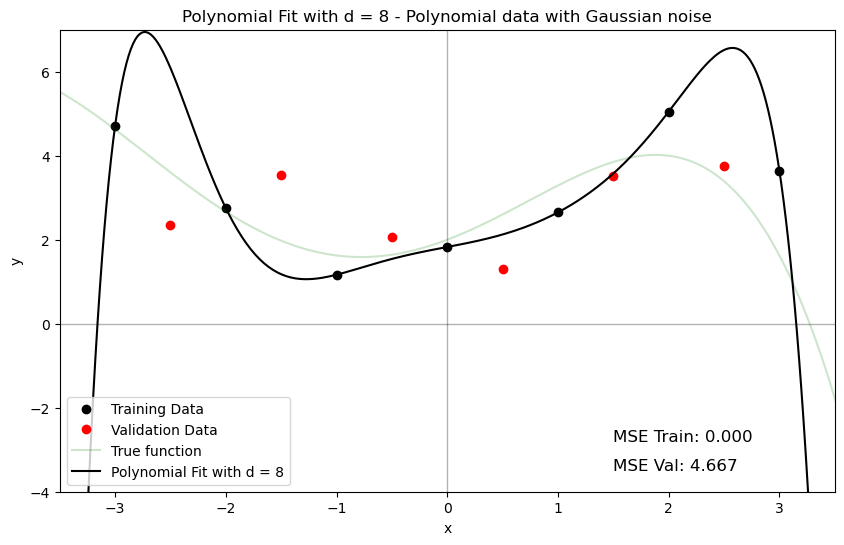

The polynomial is: 1.827413876 +0.3323047041 x +0.01697686312 x**2 +0.3016763915 x**3 +0.02538110219 x**4 +0.1946640504 x**5 +0.04482487172 x**6 -0.09387684623 x**7 -0.004958727816 x**8 +0.007535599834 x**9 



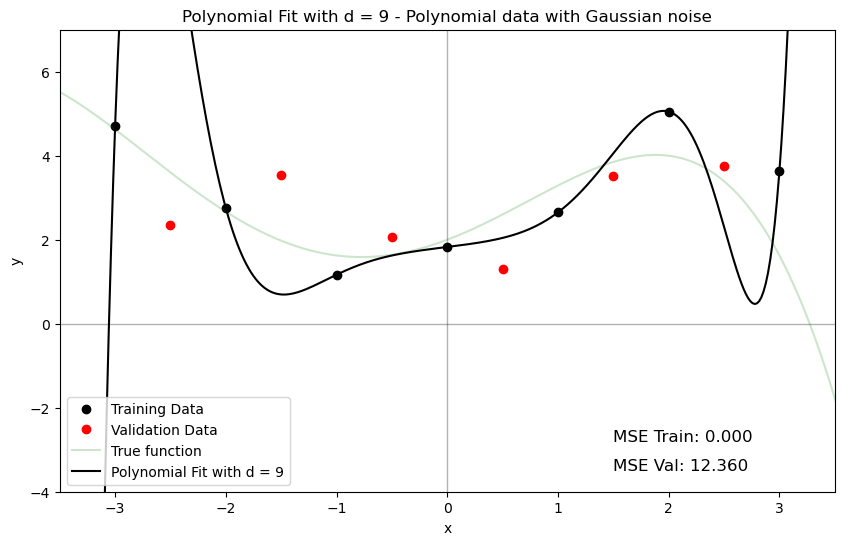

In [24]:
# Assuming polynomial_fits is a list of PolynomialTF objects and solutions is a list of tuples containing the degree,
# omega solutions, polynomial objects, MSE for training, and MSE for validation.

# Example preparation (ensure these are defined appropriately in your actual code)
# polynomial_fits = [PolynomialTF(omega_solution)(x) for d in range(8)]
# solutions = [(d, omega_hat, poly, MSE_train, MSE_val) for d, omega_hat, poly, MSE_train, MSE_val in ...]

def plot_polynomial_fits(x_train: tf.Tensor,
                         y_train: tf.Tensor,
                         x_val: tf.Tensor,
                         y_val: tf.Tensor,
                         polynomial_fits: List[PolynomialTF],
                         solutions: List[Tuple[int, tf.Tensor, PolynomialTF, tf.Tensor, tf.Tensor]],
                         dataset_name: str = "Dataset"
                        ) -> None:
    """Plots polynomial fits along with the training and validation data.
    
    Args:
        x_train: Training data x-values.
        y_train: Training data y-values.
        x_val: Validation data x-values.
        y_val: Validation data y-values.
        polynomial_fits: A list of polynomial fitting functions.
        solutions: A list of tuples containing information about each fit, including MSE for training and validation data.
    """
    for i in range(len(polynomial_fits)):
        print("The polynomial is:", polynomial_fits[i], "\n")
        plt.figure(figsize=(10, 6))
        plt.plot(x_train, y_train, 'o', label='Training Data', color='black')
        plt.plot(x_val, y_val, 'o', label='Validation Data', color='red')

        # Generate x values for plotting
        #x_values: np.ndarray = np.linspace(-4, 4, 400)
        x_values: tf.Tensor = tf.cast(tf.linspace(-4., 4., 400), dtype=tf.float64)
        
        # Generate y values for the original function and its polynomial fit
        y_values_func: tf.Tensor = y(x_values)
        y_values_fit: tf.Tensor = polynomial_fits[i](x_values)

        # Display MSE values as text on the plot
        mse_train: tf.Tensor = solutions[i][3]
        mse_val: tf.Tensor = solutions[i][4]
        plt.text(1.5, -2.8, f'MSE Train: {mse_train:.3f}', fontsize=12, color='black')
        plt.text(1.5, -3.5, f'MSE Val: {mse_val:.3f}', fontsize=12, color='black')
        
        # Plot the function and polynomial fit
        plt.plot(x_values, y_values_func, label='True function', color='green', alpha=0.2)
        plt.plot(x_values, y_values_fit, label=f'Polynomial Fit with d = {i}', color='black')
        
        # Draw axes
        plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
        
        # Finalizing plot
        plt.title(f'Polynomial Fit with d = {i} - '+dataset_name)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(loc='lower left')
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4, 7)
        plt.show()

plot_polynomial_fits(x_train, y_train, x_val, y_val, polynomial_fits, solutions, "Polynomial data with Gaussian noise")


## Stochastic solution (non-polynomial data)

In [25]:
def y(x: tf.Tensor) -> tf.Tensor:
    """Computes the function 3 + sin(x) - cos(x) for given x values.
    
    Args:
        x: A tf tensor of x values.
    
    Returns:
        A tf tensor of y values computed from the function.
    """
    return 3. + tf.sin(x) - tf.cos(x)

def y_stat(x: tf.Tensor) -> tf.Tensor:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.
    
    Args:
        x: A tf tensor of x values.
    
    Returns:
        A tf tensor of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values: tf.Tensor = y(x)
    
    # Add Gaussian noise with a mean of 0 and standard deviation of 1 to the true y values
    noisy_y_values: tf.Tensor = true_y_values + tf.random.normal(tf.shape(true_y_values), mean=0.0, stddev=1.0, dtype=tf.float64)
    
    return noisy_y_values

In [26]:
# Generate data coordinates
x_train: tf.Tensor = tf.range(-3, 4, 1, dtype=tf.float64)
x_val: tf.Tensor = tf.range(-2.5, 3.5, 1, dtype=tf.float64)

# Generate target values
tf.random.set_seed(100)
y_train: tf.Tensor = y_stat(x_train)
y_val: tf.Tensor = y_stat(x_val)

# Prepare a list to store solutions
solutions: List[Tuple[Any, tf.Tensor, PolynomialTF, tf.Tensor, tf.Tensor]] = []

# Perform the fit for each degree and print the results
show: bool = True
for d in range(10):
    # Generate the design matrix
    X_train: tf.Tensor = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: tf.Tensor = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: PolynomialTF = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: tf.Tensor = MSE(omega_hat, x_train, y_train)
    MSE_val: tf.Tensor = MSE(omega_hat, x_val, y_val)
    
    # Store the results
    solutions.append((d, omega_hat, poly, MSE_train, MSE_val))
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        #print(f"The hypothesis is: {poly}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")
polynomial_fits = [sol[2] for sol in solutions]

---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]

The solution for omega is: [3.38642428]

The polynomial is: 3.386424276

The MSE for the training data is: 2.9171697682334425
The MSE for the validation data is: 1.670768249119105

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
[[ 1. -3.]
 [ 1. -2.]
 [ 1. -1.]
 [ 1.  0.]
 [ 1.  1.]
 [ 1.  2.]
 [ 1.  3.]]

The solution for omega is: [3.38642428 0.48841816]

The polynomial is: 3.386424276 +0.4884181621 x

The MSE for the training data is: 1.962960564019351
The MSE for the validation data is: 1.2620709076700949

---------------------- d = 2 ----------------------
The degree of the polynomial is: 2

The design matrix is:
[[ 1. -3.  9.]
 [ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]
 [ 1.  3.  9.]]

The solution for omega is: [1.87851061 0.48841816 0

The polynomial is: 3.386424276 



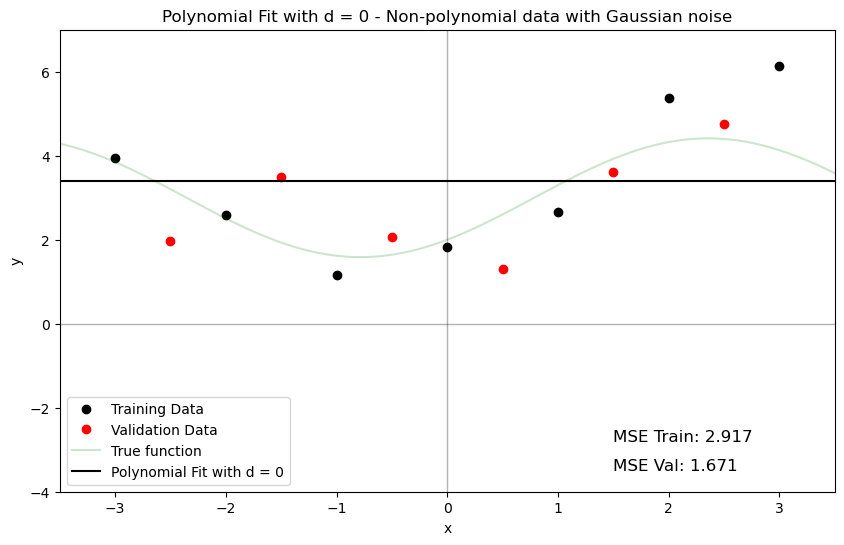

The polynomial is: 3.386424276 +0.4884181621 x 



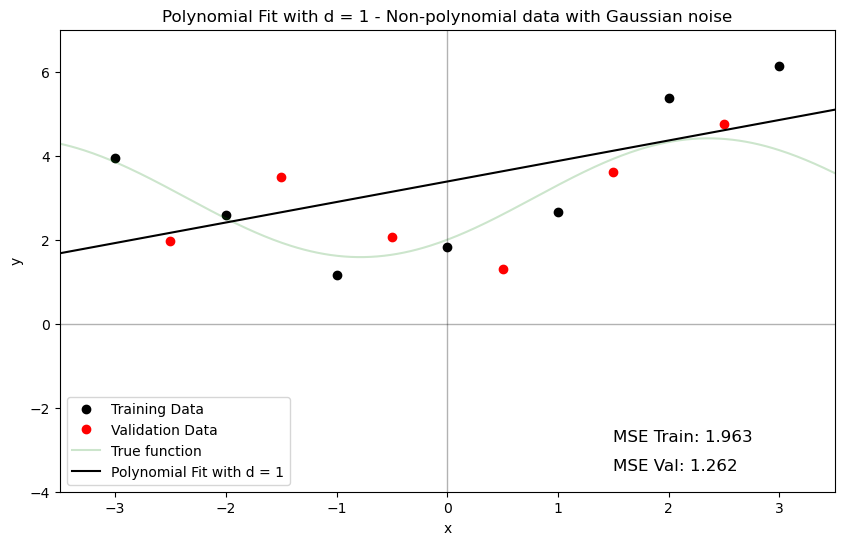

The polynomial is: 1.87851061 +0.4884181621 x +0.3769784165 x**2 



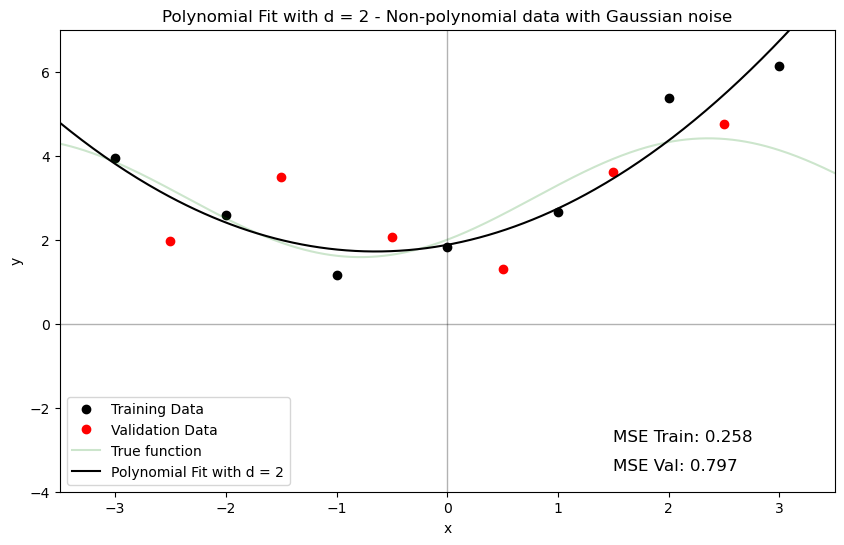

The polynomial is: 1.87851061 +0.8932995211 x +0.3769784165 x**2 -0.05784019414 x**3 



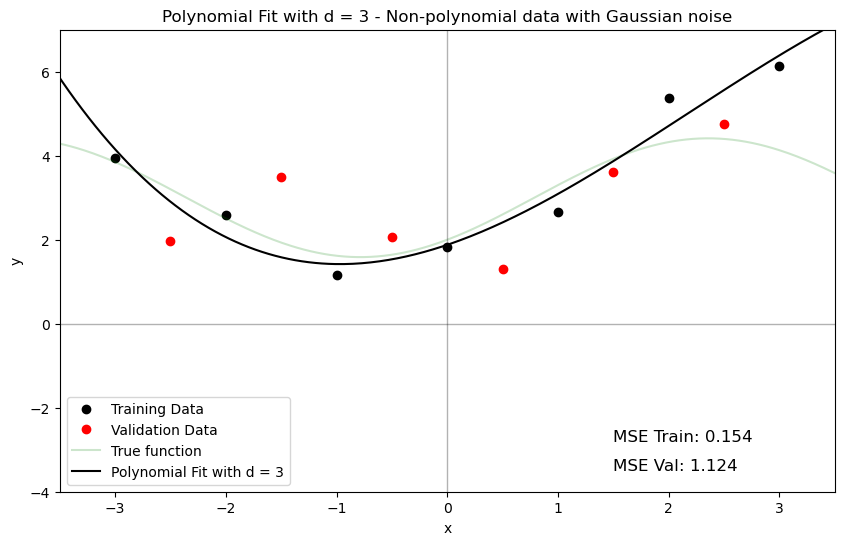

The polynomial is: 1.460900623 +0.8932995211 x +0.7655877093 x**2 -0.05784019414 x**3 -0.04060097089 x**4 



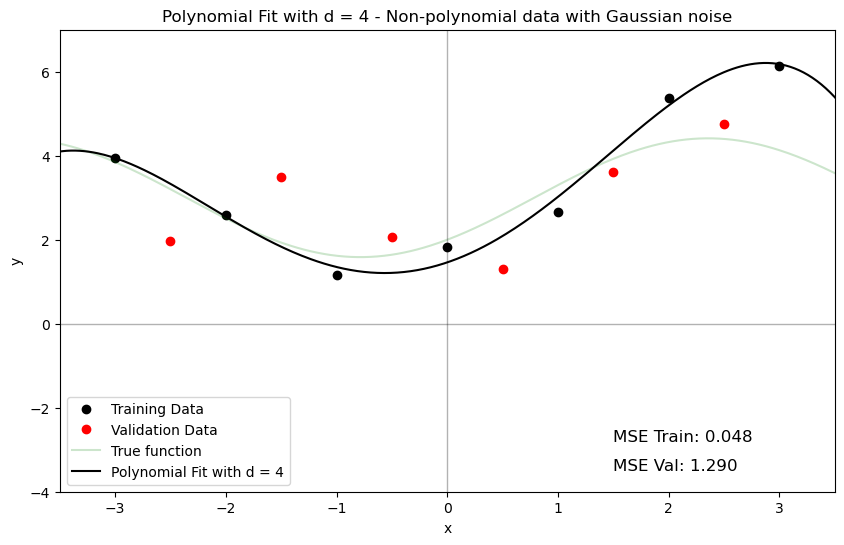

The polynomial is: 1.460900623 +0.7448018058 x +0.7655877093 x**2 +0.01159098951 x**3 -0.04060097089 x**4 -0.005951244313 x**5 



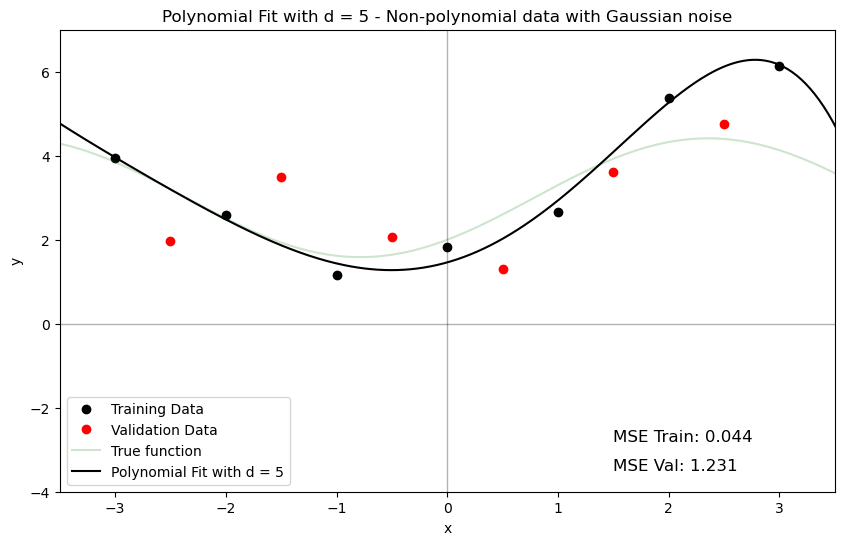

The polynomial is: 1.827413987 +0.7448018058 x -0.1623019553 x**2 +0.01159098951 x**3 +0.2694082489 x**4 -0.005951244313 x**5 -0.02351794081 x**6 



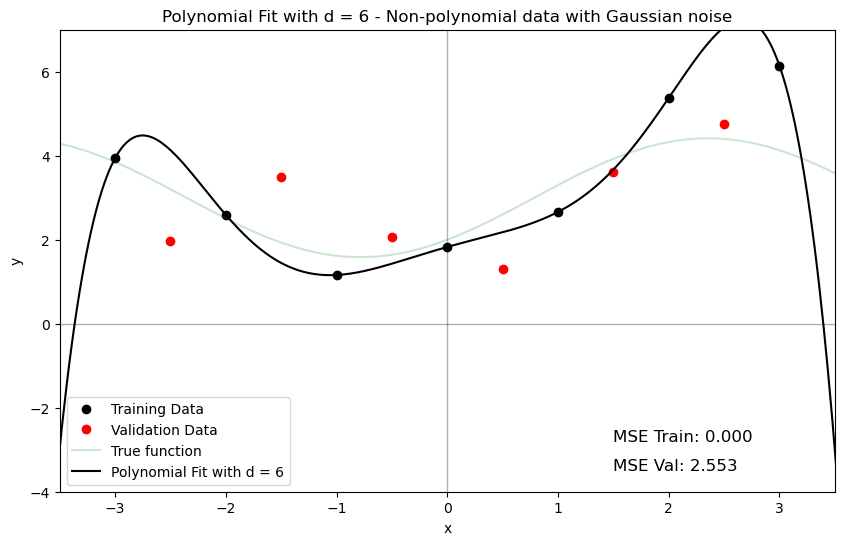

The polynomial is: 1.827413987 +0.5029381161 x -0.1623019553 x**2 +0.340794345 x**3 +0.2694082489 x**4 -0.1000093459 x**5 -0.02351794081 x**6 +0.006718435825 x**7 



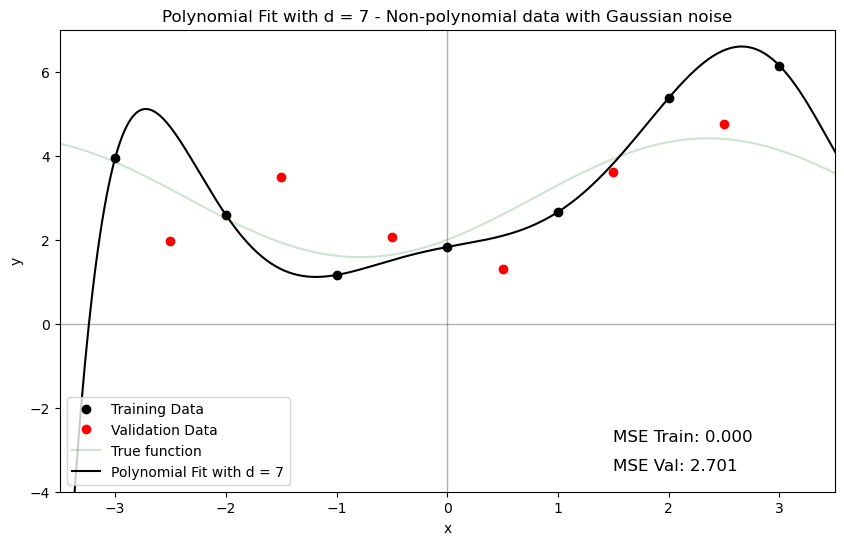

The polynomial is: 1.827413987 +0.5029381161 x +0.01680244304 x**2 +0.3407943449 x**3 +0.02562726221 x**4 -0.1000093459 x**5 +0.04613376967 x**6 +0.006718435825 x**7 -0.004975122177 x**8 



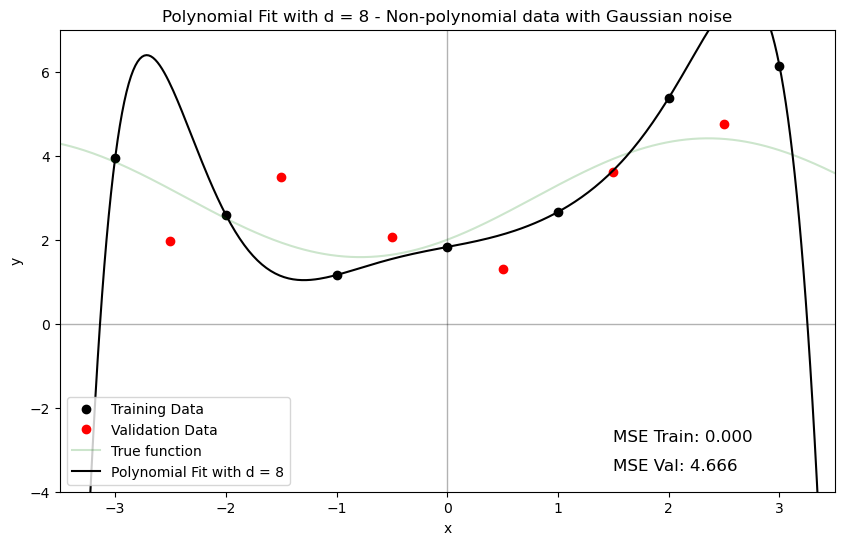

The polynomial is: 1.827413875 +0.3345134287 x +0.01680252859 x**2 +0.3038679047 x**3 +0.02562731768 x**4 +0.1967806792 x**5 +0.04613374385 x**6 -0.09211410481 x**7 -0.004975120094 x**8 +0.007393643155 x**9 



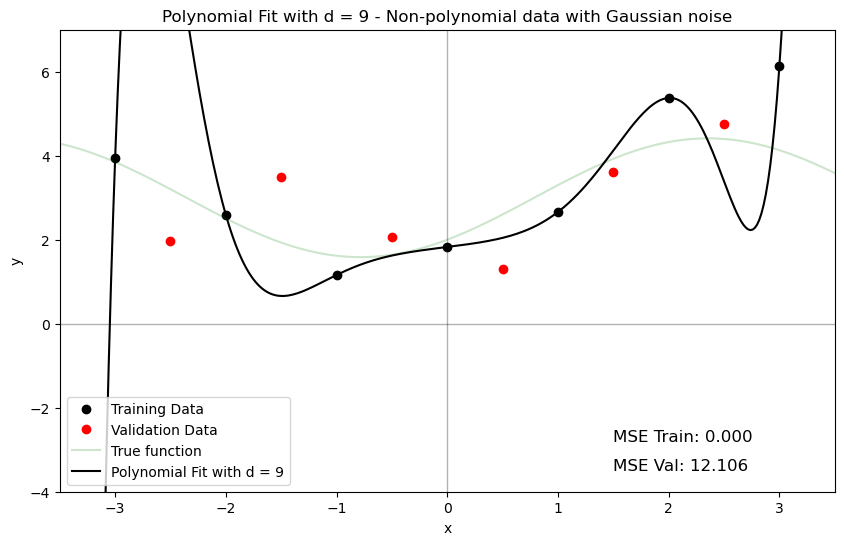

In [27]:
plot_polynomial_fits(x_train, y_train, x_val, y_val, polynomial_fits, solutions, "Non-polynomial data with Gaussian noise")

## Stochastic solution with non-polynomial fit (non-polynomial data)

In [28]:
def y(x: tf.Tensor) -> tf.Tensor:
    """Computes the function 3 + sin(x) - cos(x) for given x values.
    
    Args:
        x: A tf tensor of x values.
    
    Returns:
        A tf tensor of y values computed from the function.
    """
    return 3. + tf.sin(x) - tf.cos(x)

def y_stat(x: tf.Tensor) -> tf.Tensor:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.
    
    Args:
        x: A tf tensor of x values.
    
    Returns:
        A tf tensor of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values: tf.Tensor = y(x)
    
    # Add Gaussian noise with a mean of 0 and standard deviation of 1 to the true y values
    noisy_y_values: tf.Tensor = true_y_values + tf.random.normal(tf.shape(true_y_values), mean=0.0, stddev=1.0, dtype=tf.float64)
    
    return noisy_y_values

def y_stat_np(x: np.ndarray) -> np.ndarray:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values: np.ndarray = y(x).numpy()
    
    # Add Gaussian noise with a mean of 0 and standard deviation of 1 to the true y values
    noisy_y_values: np.ndarray = np.random.normal(true_y_values, 1)
    
    return tf.cast(noisy_y_values, dtype=tf.float64)

def design_matrix_trig_tf(x_values: tf.Tensor) -> tf.Tensor:
    """Generates a design matrix for trigonometric regression with TensorFlow.
    
    Args:
        x_values: A tf.Tensor of x values.
    
    Returns:
        A tf.Tensor representing the design matrix with columns for 1, sin(x), and cos(x).
    """
    ones = tf.ones_like(x_values)
    sin_x = tf.sin(x_values)
    cos_x = tf.cos(x_values)
    # Stack along the second dimension (axis=1) to form the design matrix
    return tf.stack([ones, sin_x, cos_x], axis=1)

def omega_solution(X: tf.Tensor, 
                   Y: tf.Tensor
                  ) -> tf.Tensor:
    """Calculates the polynomial coefficients (omega) that best fit the data.
    
    Args:
        X: The design matrix.
        Y: A tf tensor of target y values.
    
    Returns:
        A tf tensor of calculated omega values.
    """
    XT: tf.Tensor = tf.transpose(X)
    Y: tf.Tensor = tf.reshape(Y, (-1, 1))
    omega: tf.Tensor = tf.linalg.pinv(XT @ X) @ XT @ Y
    return tf.reshape(omega, [-1])

def trig_solution(omega_solution: tf.Tensor, 
                  x_values: tf.Tensor
                 ) -> tf.Tensor:
    """Evaluates the trigonometric model at given x values using the omega coefficients.
    
    Args:
        omega_solution: A tf.Tensor of omega coefficients for [constant, sin(x), cos(x)].
        x_values: A tf.Tensor of x values for evaluation.
    
    Returns:
        A tf.Tensor of y values predicted by the trigonometric model.
    """
    return omega_solution[0] + omega_solution[1] * tf.sin(x_values) + omega_solution[2] * tf.cos(x_values)

def MSE(omega_solution: tf.Tensor, 
        x_values: tf.Tensor,
        y_true: tf.Tensor
       ) -> tf.Tensor:
    """Calculates the Mean Squared Error (MSE) for given omega coefficients and x values.
    
    Args:
        omega_solution: A 1D tf.Tensor of omega coefficients.
        x_values: A 1D tf.Tensor of x values for evaluation.
    
    Returns:
        The MSE as a tf.Tensor.
    """
    y_pred: tf.Tensor = trig_solution(omega_solution, x_values)
    return tf.reduce_mean(tf.square(y_true - y_pred))


In [29]:
# Generate data coordinates
x_train: tf.Tensor = tf.range(-3, 4, 1, dtype=tf.float64)
x_val: tf.Tensor = tf.range(-2.5, 3.5, 1, dtype=tf.float64)

# Generate target values through the statistical model with tf
tf.random.set_seed(100)
y_train: tf.Tensor = y_stat(x_train)
y_val: tf.Tensor = y_stat(x_val)

# Flag to control printing of the solution details
show: bool = True

# Generate the design matrix
X_train: tf.Tensor = design_matrix_trig_tf(x_train)

# Compute the weights of the solution
omega_hat: tf.Tensor = omega_solution(X_train, y_train)

# Compute the MSE for the training and validation data
MSE_train: tf.Tensor = MSE(omega_hat, x_train, y_train)
MSE_val: tf.Tensor = MSE(omega_hat, x_val, y_val)

# Print the results
if show:
    print("----------------- Trigonometric Model -----------------")
    print(f"The design matrix is:\n{X_train}\n")
    print(f"The target values are:\n{y_train}\n")
    print(f"The solution for omega is: {omega_hat}\n")
    print(f"The MSE for the training data is: {MSE_train}")
    print(f"The MSE for the validation data is: {MSE_val}\n")

----------------- Trigonometric Model -----------------
The design matrix is:
[[ 1.         -0.14112001 -0.9899925 ]
 [ 1.         -0.90929743 -0.41614684]
 [ 1.         -0.84147098  0.54030231]
 [ 1.          0.          1.        ]
 [ 1.          0.84147098  0.54030231]
 [ 1.          0.90929743 -0.41614684]
 [ 1.          0.14112001 -0.9899925 ]]

The target values are:
[3.94297593 2.59169823 1.16056079 1.82741399 2.66144389 5.37548165
 6.14539546]

The solution for omega is: [ 3.19642425  1.32011047 -1.81774952]

The MSE for the training data is: 0.3427335003902933
The MSE for the validation data is: 1.6295062523819805



In [30]:
# Generate data coordinates
x_train: tf.Tensor = tf.range(-3, 4, 1, dtype=tf.float64)
x_val: tf.Tensor = tf.range(-2.5, 3.5, 1, dtype=tf.float64)

# Generate target values through the statistical model with tf
#tf.random.set_seed(100)
#y_train: tf.Tensor = y_stat(x_train)
#y_val: tf.Tensor = y_stat(x_val)
# To reproduce the same results as with numpy
np.random.seed(100)
y_train: np.ndarray = y_stat_np(x_train)
y_val: np.ndarray = y_stat_np(x_val)

# Flag to control printing of the solution details
show: bool = True

# Generate the design matrix
X_train: tf.Tensor = design_matrix_trig_tf(x_train)

# Compute the weights of the solution
omega_hat: tf.Tensor = omega_solution(X_train, y_train)

# Compute the MSE for the training and validation data
MSE_train: tf.Tensor = MSE(omega_hat, x_train, y_train)
MSE_val: tf.Tensor = MSE(omega_hat, x_val, y_val)

# Print the results
if show:
    print("----------------- Trigonometric Model -----------------")
    print(f"The design matrix is:\n{X_train}\n")
    print(f"The target values are:\n{y_train}\n")
    print(f"The solution for omega is: {omega_hat}\n")
    print(f"The MSE for the training data is: {MSE_train}")
    print(f"The MSE for the validation data is: {MSE_val}\n")

----------------- Trigonometric Model -----------------
The design matrix is:
[[ 1.         -0.14112001 -0.9899925 ]
 [ 1.         -0.90929743 -0.41614684]
 [ 1.         -0.84147098  0.54030231]
 [ 1.          0.          1.        ]
 [ 1.          0.84147098  0.54030231]
 [ 1.          0.90929743 -0.41614684]
 [ 1.          0.14112001 -0.9899925 ]]

The target values are:
[2.09910702 2.84952981 2.77126251 1.74756396 4.28248947 4.8396631
 4.35229217]

The solution for omega is: [ 3.23274463  1.09313872 -0.42737018]

The MSE for the training data is: 0.6231208529025826
The MSE for the validation data is: 0.4426790841588116



Fit with true function



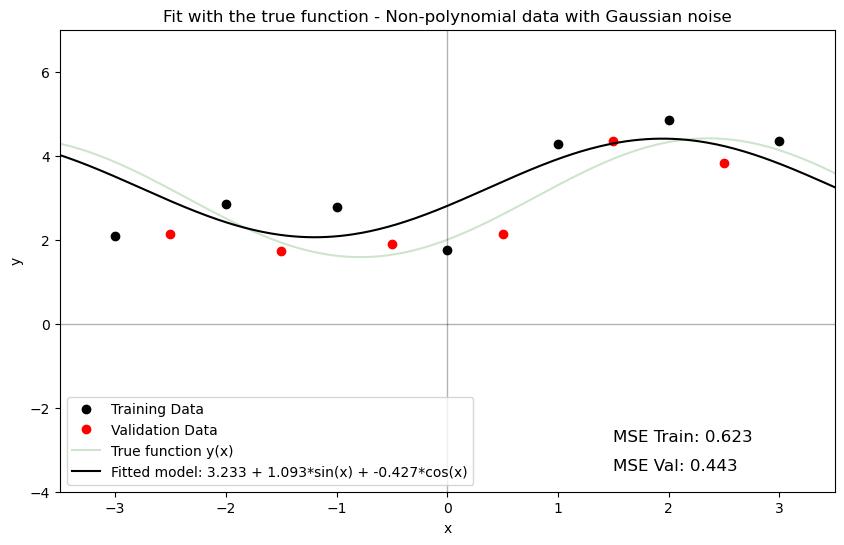

In [31]:
print("Fit with true function\n")
omega_hat_str = f"{omega_hat[0]:.3f} + {omega_hat[1]:.3f}*sin(x) + {omega_hat[2]:.3f}*cos(x)"
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_train, 'o', label='Training Data', color='black')
plt.plot(x_val, y_val, 'o', label='Validation Data', color='red')

# Generate x values for plotting
x_values: tf.Tensor = tf.cast(tf.linspace(-4., 4., 400), dtype=tf.float64)

# Generate y values for the function and the model fit
y_values_func: tf.Tensor = y(x_values)
y_values_fit: tf.Tensor = trig_solution(omega_hat, x_values)  # Use trig_solution instead of poly_solution

plt.text(1.5, -2.8, f'MSE Train: {MSE_train:.3f}', fontsize=12, color='black')
plt.text(1.5, -3.5, f'MSE Val: {MSE_val:.3f}', fontsize=12, color='black')
    
plt.plot(x_values, y_values_func, label='True function y(x)', color='green', alpha=0.2)
plt.plot(x_values, y_values_fit, label='Fitted model: ' + omega_hat_str, color='black')

# Drawing axes
plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.3)

# Finalizing plot
plt.title(f'Fit with the true function - Non-polynomial data with Gaussian noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower left')
plt.xlim(-3.5, 3.5)
plt.ylim(-4, 7)
plt.show()


# PyTorch code

## Deterministic solution (polynomial data)

In [32]:
class PolynomialTorch:
    def __init__(self, coefficients):
        """
        Initializes the polynomial with given coefficients.

        Args:
            coefficients: A 1D torch.Tensor or a Python list of polynomial coefficients
                          from the lowest to the highest degree.
        """
        self.coefficients = torch.tensor(coefficients, dtype=torch.float64)

    def __call__(self, x):
        """
        Evaluates the polynomial at given x values.

        Args:
            x: A 1D torch.Tensor or a list of x values where the polynomial is to be evaluated.

        Returns:
            A torch.Tensor containing the evaluated polynomial values at each x value.
        """
        x = torch.tensor(x, dtype=torch.float64)
        degree = self.coefficients.shape[0]
        x_powers = torch.pow(x.unsqueeze(-1), torch.arange(0, degree, dtype=torch.float64))
        poly_values = torch.sum(x_powers * self.coefficients, dim=1)
        return poly_values

    def __str__(self):
        """
        Returns a string representation of the polynomial.
        """
        terms = []
        for i, coeff in enumerate(self.coefficients.numpy()):
            if coeff != 0:  # Skip terms with a coefficient of zero
                if i == 0:
                    terms.append(f"{coeff:.10g}")
                elif i == 1:
                    terms.append(f"{coeff:+.10g} x")
                else:
                    terms.append(f"{coeff:+.10g} x**{i}")
        return " ".join(terms)

In [35]:
def y(x: torch.Tensor) -> torch.Tensor:
    """Generates polynomial data based on a given polynomial expression.
    
    Args:
        x: A torch tensor of x values.
    
    Returns:
        A torch tensor of y values computed from the polynomial expression.
    """
    return (-torch.pow(x, 4)/24 - torch.pow(x, 3)/6 + torch.pow(x, 2)/2 + x + 2).to(torch.float64)

def design_matrix(degree: int, x_values: torch.Tensor) -> torch.Tensor:
    """Generates a design matrix for polynomial regression of a specified degree.
    
    Args:
        degree: The degree of the polynomial hypothesis.
        x_values: A torch tensor of x values.
    
    Returns:
        A design matrix as a torch tensor.
    """
    return torch.stack([x_values**i for i in range(degree + 1)], dim=1)

def omega_solution(X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
    """Calculates the polynomial coefficients (omega) that best fit the data.
    
    Args:
        X: The design matrix.
        Y: A torch tensor of target y values.
    
    Returns:
        A torch tensor of calculated omega values.
    """
    XT: torch.Tensor = X.T
    Y: torch.Tensor = Y.view(-1, 1)  # Reshape to column vector
    omega: torch.Tensor = torch.linalg.pinv(XT @ X) @ XT @ Y
    return omega.view(-1)  # Flatten

def poly_solution(omega_solution: torch.Tensor) -> PolynomialTorch:
    """Converts omega coefficients to a torch PolynomialTorch object.
    
    Args:
        omega_solution: A torch.Tensor of omega coefficients.
    
    Returns:
        A torch PolynomialTorch object representing the fitted polynomial.
    """
    return PolynomialTorch(omega_solution)

def MSE(omega_solution: torch.Tensor, x_values: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """Calculates the Mean Squared Error (MSE) for given omega coefficients and x values.
    
    Args:
        omega_solution: A 1D torch.Tensor of omega coefficients.
        x_values: A 1D torch.Tensor of x values for evaluation.
        y_true: A 1D torch.Tensor of true y values.
    
    Returns:
        The MSE as a torch.Tensor.
    """
    poly: PolynomialTorch = poly_solution(omega_solution)
    y_pred: torch.Tensor = poly(x_values)
    return torch.mean((y_true - y_pred) ** 2)

In [36]:
# Generate data coordinates
x_train: torch.Tensor = torch.arange(-3, 4, 1, dtype=torch.float64)
x_val: torch.Tensor = torch.arange(-2.5, 3.5, 1, dtype=torch.float64)

# Generate target values
y_train: torch.Tensor = y(x_train)
y_val: torch.Tensor = y(x_val)

# Perform the fit for each degree and print the results
show: bool = True
for d in range(8):
    # Generate the design matrix
    X_train: torch.Tensor = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: torch.Tensor = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly: PolynomialTorch = poly_solution(omega_hat)
    
    # Compute the MSE for the training and validation data
    MSE_train: torch.Tensor = MSE(omega_hat, x_train, y_train)
    MSE_val: torch.Tensor = MSE(omega_hat, x_val, y_val)
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")

---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=torch.float64)

The solution for omega is: tensor([2.8333], dtype=torch.float64)

The polynomial is: 2.833333333

The MSE for the training data is: 1.2033730158730158
The MSE for the validation data is: 0.6907619900173612

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
tensor([[ 1., -3.],
        [ 1., -2.],
        [ 1., -1.],
        [ 1.,  0.],
        [ 1.,  1.],
        [ 1.,  2.],
        [ 1.,  3.]], dtype=torch.float64)

The solution for omega is: tensor([ 2.8333, -0.1667], dtype=torch.float64)

The polynomial is: 2.833333333 -0.1666666667 x

The MSE for the training data is: 1.0922619047619049
The MSE for the validation data is: 0.925715693721065

---------------------- d = 2 ----------------------
The d

/tmp/ipykernel_2756236/1536676131.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coefficients = torch.tensor(coefficients, dtype=torch.float64)
/tmp/ipykernel_2756236/1536676131.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)


## Deterministic solution (non-polynomial data)

In [37]:
def y(x: torch.Tensor) -> torch.Tensor:
    """Computes the function 3 + sin(x) - cos(x) for given x values.
    
    Args:
        x: A torch tensor of x values.
    
    Returns:
        A torch tensor of y values computed from the function.
    """
    return 3. + torch.sin(x) - torch.cos(x)

In [38]:
# Generate data coordinates
x_train = torch.arange(-3, 4, 1, dtype=torch.float64)
x_val = torch.arange(-2.5, 3.5, 1, dtype=torch.float64)

# Generate target values
y_train = y(x_train)
y_val = y(x_val)

# Perform the fit for each degree and print the results
show = True
for d in range(10):
    # Generate the design matrix
    X_train = design_matrix(d, x_train)

    # Compute the weights of the solution
    omega_hat = omega_solution(X_train, y_train)

    # Define the fit polynomial
    poly = poly_solution(omega_hat)

    # Compute the MSE for the training and validation data
    MSE_train = MSE(omega_hat, x_train, y_train)
    MSE_val = MSE(omega_hat, x_val, y_val)

    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")

---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=torch.float64)

The solution for omega is: tensor([3.1045], dtype=torch.float64)

The polynomial is: 3.104524865

The MSE for the training data is: 0.9890745526099051
The MSE for the validation data is: 1.0211811587186355

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
tensor([[ 1., -3.],
        [ 1., -2.],
        [ 1., -1.],
        [ 1.,  0.],
        [ 1.,  1.],
        [ 1.,  2.],
        [ 1.,  3.]], dtype=torch.float64)

The solution for omega is: tensor([3.1045, 0.2202], dtype=torch.float64)

The polynomial is: 3.104524865 +0.2202447045 x

The MSE for the training data is: 0.7950436332141865
The MSE for the validation data is: 0.6880882026927809

---------------------- d = 2 ----------------------
The de

/tmp/ipykernel_2756236/1536676131.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coefficients = torch.tensor(coefficients, dtype=torch.float64)
/tmp/ipykernel_2756236/1536676131.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)


## Stochastic solution (polynomial data)

In [39]:
def y(x: torch.Tensor) -> torch.Tensor:
    """Generates polynomial data based on a given polynomial expression.

    Args:
        x: A torch tensor of x values.

    Returns:
        A torch tensor of y values computed from the polynomial expression.
    """
    return (-torch.pow(x, 4) / 24 - torch.pow(x, 3) / 6 + torch.pow(x, 2) / 2 + x + 2).double()

def y_stat(x: torch.Tensor) -> torch.Tensor:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.

    Args:
        x: A torch tensor of x values.

    Returns:
        A torch tensor of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values = y(x)

    # Add Gaussian noise with mean 0 and standard deviation 1
    noisy_y_values = torch.normal(mean=true_y_values, std=1.0)

    return noisy_y_values

In [40]:
# Generate data coordinates
x_train: torch.Tensor = torch.arange(-3, 4, 1, dtype=torch.float64)
x_val: torch.Tensor = torch.arange(-2.5, 3.5, 1, dtype=torch.float64)

# Generate target values with noise
torch.manual_seed(100)
y_train: torch.Tensor = y_stat(x_train)
y_val: torch.Tensor = y_stat(x_val)

# Prepare a list to store solutions
solutions: List[Tuple[Any, torch.Tensor, Any, torch.Tensor, torch.Tensor]] = []

# Perform the fit for each degree and print the results
show: bool = True
for d in range(10):
    # Generate the design matrix
    X_train: torch.Tensor = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: torch.Tensor = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly = poly_solution(omega_hat)  # Assuming `poly_solution` is adapted for PyTorch
    
    # Compute the MSE for the training and validation data
    MSE_train: torch.Tensor = MSE(omega_hat, x_train, y_train)
    MSE_val: torch.Tensor = MSE(omega_hat, x_val, y_val)
    
    # Store the results
    solutions.append((d, omega_hat, poly, MSE_train, MSE_val))
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        # print(f"The hypothesis is: {poly}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")

# Extract polynomial fits
polynomial_fits = [sol[2] for sol in solutions]

---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=torch.float64)

The solution for omega is: tensor([2.2490], dtype=torch.float64)

The polynomial is: 2.249033321

The MSE for the training data is: 1.4086946392237416
The MSE for the validation data is: 1.5672164111230404

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
tensor([[ 1., -3.],
        [ 1., -2.],
        [ 1., -1.],
        [ 1.,  0.],
        [ 1.,  1.],
        [ 1.,  2.],
        [ 1.,  3.]], dtype=torch.float64)

The solution for omega is: tensor([ 2.2490, -0.4195], dtype=torch.float64)

The polynomial is: 2.249033321 -0.4194555386 x

The MSE for the training data is: 0.7049228439139419
The MSE for the validation data is: 1.6286900887805114

---------------------- d = 2 ----------------------
The 

/tmp/ipykernel_2756236/1536676131.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coefficients = torch.tensor(coefficients, dtype=torch.float64)
/tmp/ipykernel_2756236/1536676131.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)


The polynomial is: 2.249033321 



/tmp/ipykernel_2756236/1536676131.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)


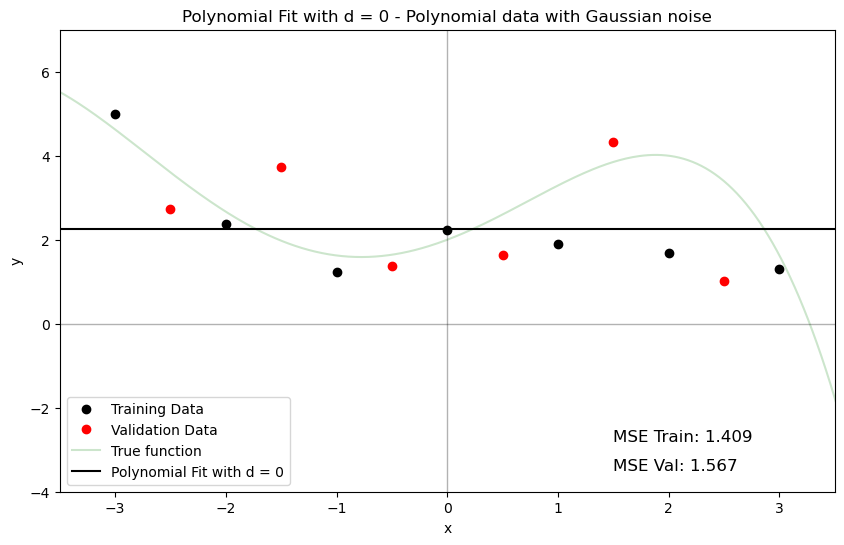

The polynomial is: 2.249033321 -0.4194555386 x 



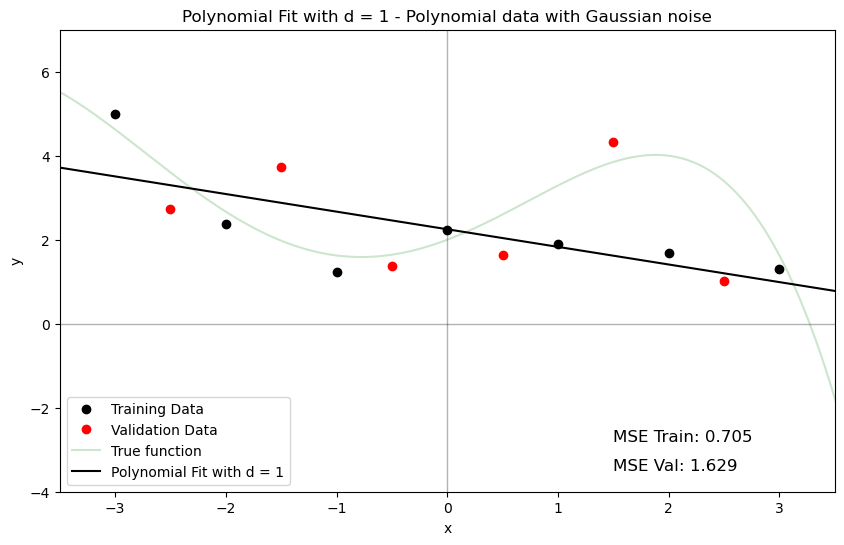

The polynomial is: 1.626320171 -0.4194555386 x +0.1556782875 x**2 



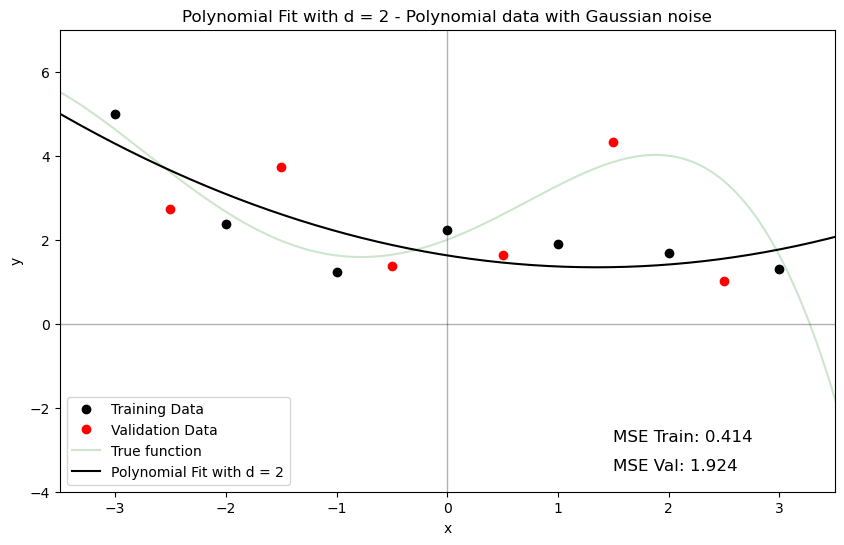

The polynomial is: 1.626320171 +0.2923726871 x +0.1556782875 x**2 -0.1016897465 x**3 



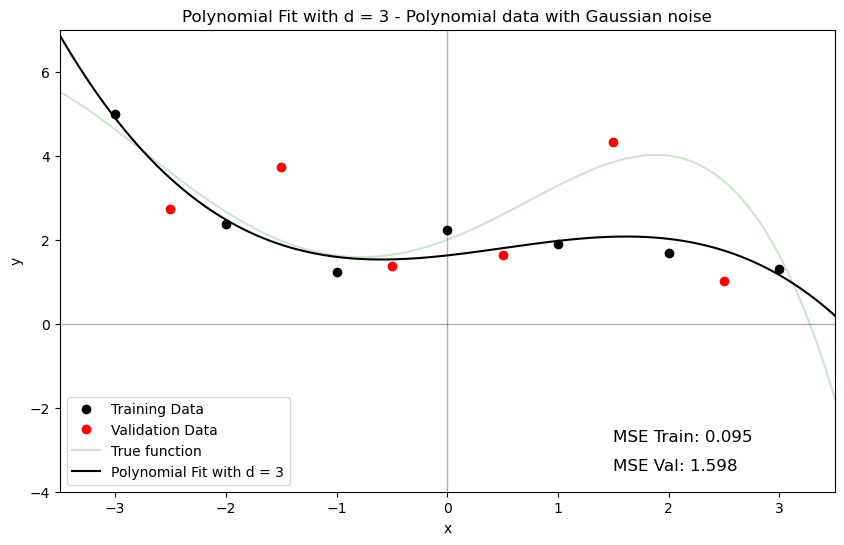

The polynomial is: 1.899295579 +0.2923726871 x -0.09834049462 x**2 -0.1016897465 x**3 +0.02653927574 x**4 



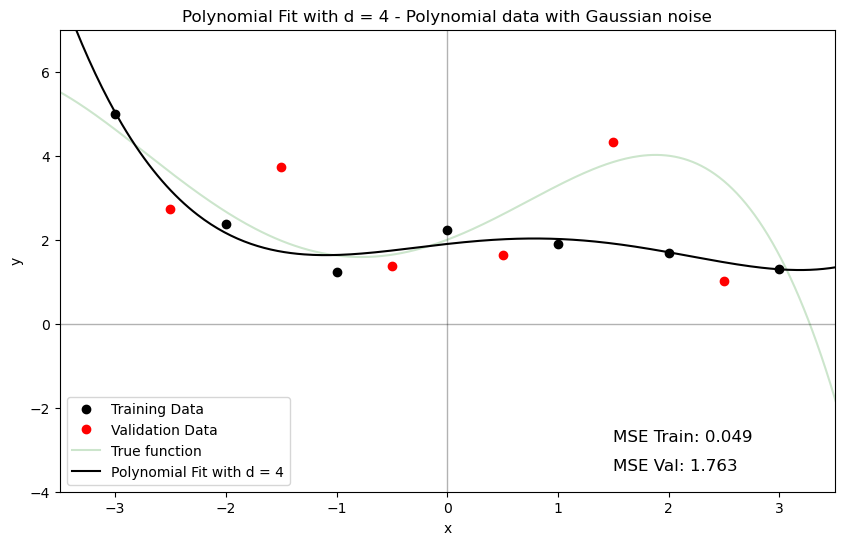

The polynomial is: 1.899295579 +0.550700738 x -0.09834049462 x**2 -0.2224729001 x**3 +0.02653927574 x**4 +0.01035284174 x**5 



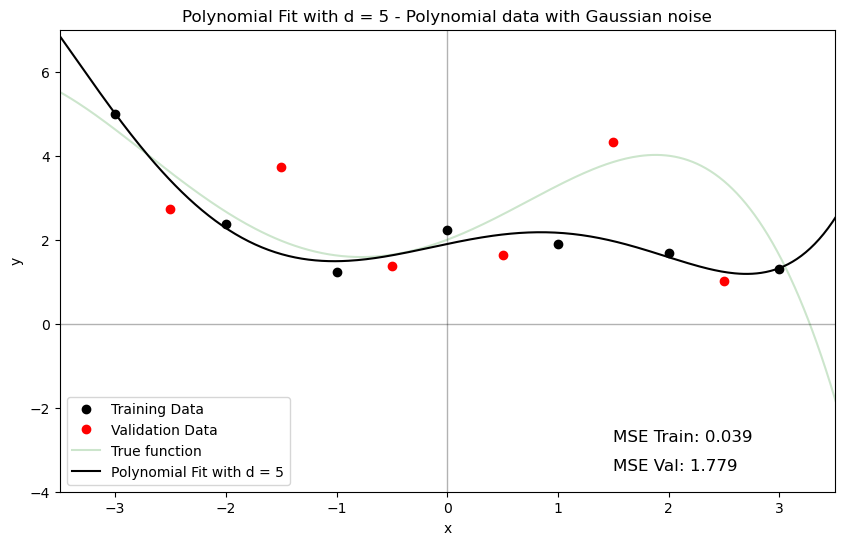

The polynomial is: 2.242937923 +0.550700738 x -0.9683283612 x**2 -0.2224729001 x**3 +0.3172034247 x**4 +0.01035284174 x**5 -0.02205038371 x**6 



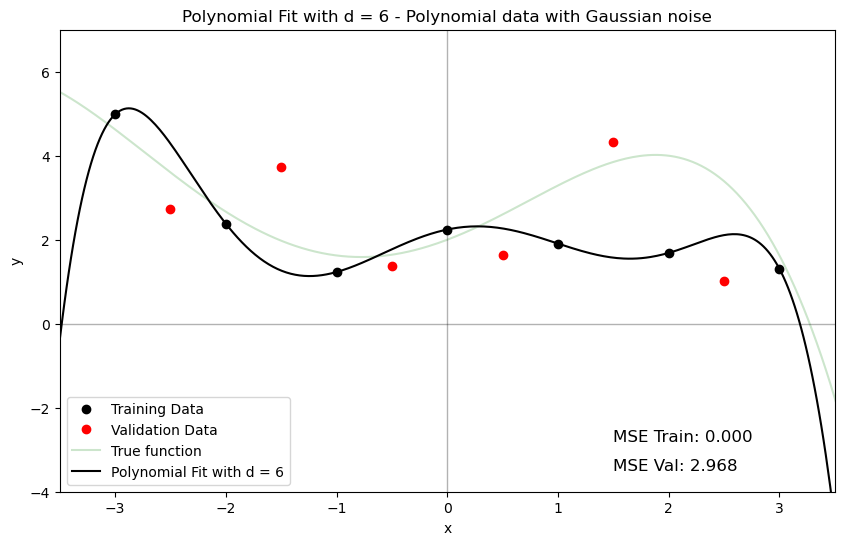

The polynomial is: 2.242937923 +0.2652954516 x -0.9683283611 x**2 +0.1659954064 x**3 +0.3172034247 x**4 -0.100638103 x**5 -0.02205038371 x**6 +0.007927924623 x**7 



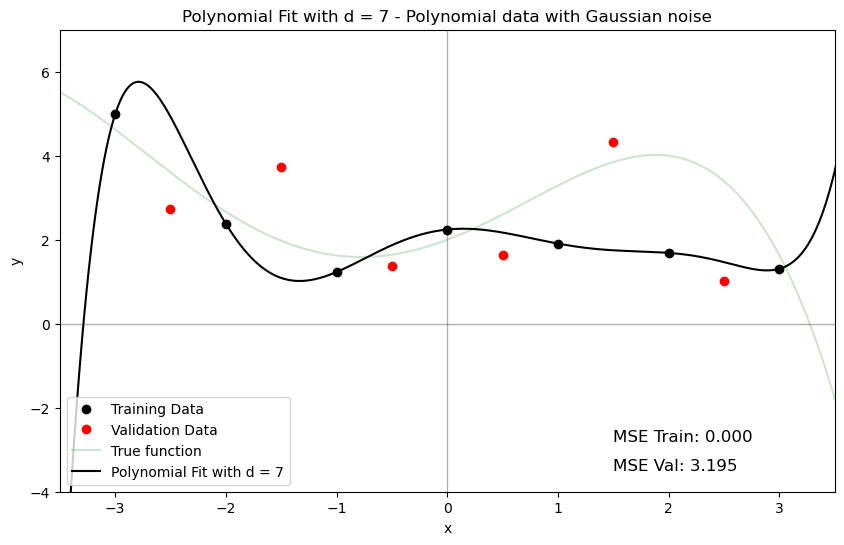

The polynomial is: 2.242937922 +0.2652954518 x -0.4995009876 x**2 +0.1659954061 x**3 -0.3209227224 x**4 -0.1006381029 x**5 +0.1602713726 x**6 +0.007927924617 x**7 -0.01302298259 x**8 



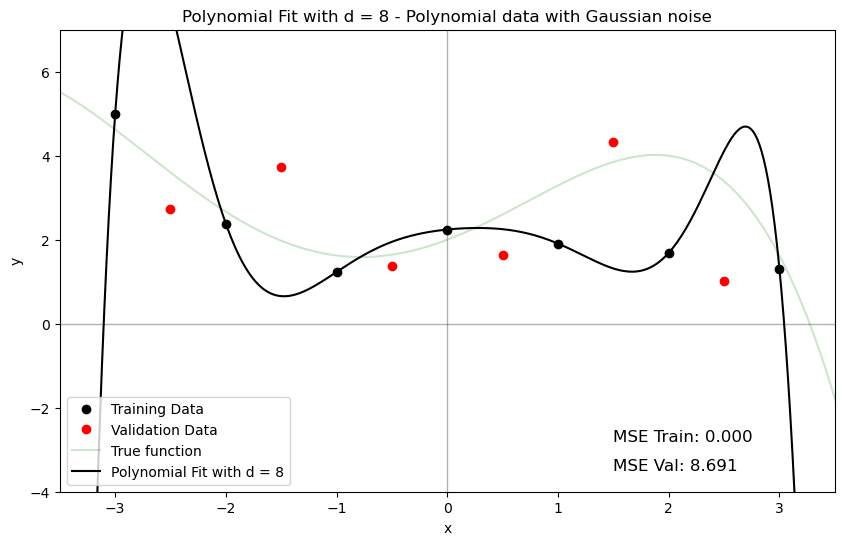

The polynomial is: 2.242937922 +0.1577992646 x -0.4995009877 x**2 +0.1424272939 x**3 -0.3209227223 x**4 +0.0887866026 x**5 +0.1602713726 x**6 -0.05515143548 x**7 -0.01302298259 x**8 +0.004718954666 x**9 



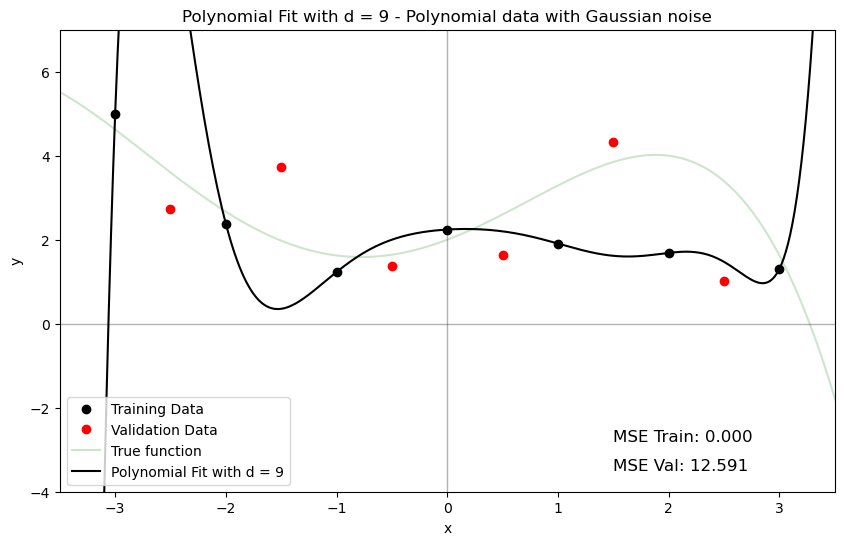

In [41]:
# Assuming polynomial_fits is a list of PolynomialTorch objects and solutions is a list of tuples containing the degree,
# omega solutions, polynomial objects, MSE for training, and MSE for validation.

# Example preparation (ensure these are defined appropriately in your actual code)
# polynomial_fits = [PolynomialTorch(omega_solution)(x) for d in range(8)]
# solutions = [(d, omega_hat, poly, MSE_train, MSE_val) for d, omega_hat, poly, MSE_train, MSE_val in ...]

def plot_polynomial_fits(x_train: torch.Tensor,
                         y_train: torch.Tensor,
                         x_val: torch.Tensor,
                         y_val: torch.Tensor,
                         polynomial_fits: List[Any],  # Replace with appropriate polynomial object type in PyTorch
                         solutions: List[Tuple[int, torch.Tensor, Any, torch.Tensor, torch.Tensor]],
                         dataset_name: str = "Dataset"
                        ) -> None:
    """Plots polynomial fits along with the training and validation data.
    
    Args:
        x_train: Training data x-values.
        y_train: Training data y-values.
        x_val: Validation data x-values.
        y_val: Validation data y-values.
        polynomial_fits: A list of polynomial fitting functions.
        solutions: A list of tuples containing information about each fit, including MSE for training and validation data.
    """
    for i in range(len(polynomial_fits)):
        print("The polynomial is:", polynomial_fits[i], "\n")
        plt.figure(figsize=(10, 6))
        plt.plot(x_train.numpy(), y_train.numpy(), 'o', label='Training Data', color='black')
        plt.plot(x_val.numpy(), y_val.numpy(), 'o', label='Validation Data', color='red')

        # Generate x values for plotting
        x_values: torch.Tensor = torch.linspace(-4., 4., 400, dtype=torch.float64)
        
        # Generate y values for the original function and its polynomial fit
        y_values_func: torch.Tensor = y(x_values)  # Assuming `y(x_values)` is defined in PyTorch
        y_values_fit: torch.Tensor = polynomial_fits[i](x_values)

        # Display MSE values as text on the plot
        mse_train: torch.Tensor = solutions[i][3]
        mse_val: torch.Tensor = solutions[i][4]
        plt.text(1.5, -2.8, f'MSE Train: {mse_train.item():.3f}', fontsize=12, color='black')
        plt.text(1.5, -3.5, f'MSE Val: {mse_val.item():.3f}', fontsize=12, color='black')
        
        # Plot the function and polynomial fit
        plt.plot(x_values.numpy(), y_values_func.numpy(), label='True function', color='green', alpha=0.2)
        plt.plot(x_values.numpy(), y_values_fit.numpy(), label=f'Polynomial Fit with d = {i}', color='black')
        
        # Draw axes
        plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
        plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
        
        # Finalizing plot
        plt.title(f'Polynomial Fit with d = {i} - {dataset_name}')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend(loc='lower left')
        plt.xlim(-3.5, 3.5)
        plt.ylim(-4, 7)
        plt.show()

# Call the function
plot_polynomial_fits(x_train, y_train, x_val, y_val, polynomial_fits, solutions, "Polynomial data with Gaussian noise")


## Stochastic solution (non-polynomial data)

In [42]:
def y(x: torch.Tensor) -> torch.Tensor:
    """Computes the function 3 + sin(x) - cos(x) for given x values.
    
    Args:
        x: A torch tensor of x values.
    
    Returns:
        A torch tensor of y values computed from the function.
    """
    return (3 + torch.sin(x) - torch.cos(x)).double()

def y_stat(x: torch.Tensor) -> torch.Tensor:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.

    Args:
        x: A torch tensor of x values.

    Returns:
        A torch tensor of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values = y(x)

    # Add Gaussian noise with mean 0 and standard deviation 1
    noisy_y_values = torch.normal(mean=true_y_values, std=1.0)

    return noisy_y_values

In [43]:
# Generate data coordinates
x_train: torch.Tensor = torch.arange(-3, 4, 1, dtype=torch.float64)
x_val: torch.Tensor = torch.arange(-2.5, 3.5, 1, dtype=torch.float64)

# Generate target values with noise
torch.manual_seed(100)
y_train: torch.Tensor = y_stat(x_train)
y_val: torch.Tensor = y_stat(x_val)

# Prepare a list to store solutions
solutions: List[Tuple[Any, torch.Tensor, Any, torch.Tensor, torch.Tensor]] = []

# Perform the fit for each degree and print the results
show: bool = True
for d in range(10):
    # Generate the design matrix
    X_train: torch.Tensor = design_matrix(d, x_train)
    
    # Compute the weights of the solution
    omega_hat: torch.Tensor = omega_solution(X_train, y_train)
    
    # Define the fit polynomial
    poly = poly_solution(omega_hat)  # Assuming `poly_solution` is adapted for PyTorch
    
    # Compute the MSE for the training and validation data
    MSE_train: torch.Tensor = MSE(omega_hat, x_train, y_train)
    MSE_val: torch.Tensor = MSE(omega_hat, x_val, y_val)
    
    # Store the results
    solutions.append((d, omega_hat, poly, MSE_train, MSE_val))
    
    # Print the results
    if show:
        print(f"===================================================")
        print(f"---------------------- d = {d} ----------------------")
        print(f"===================================================")
        print(f"The degree of the polynomial is: {d}\n")
        # print(f"The hypothesis is: {poly}\n")
        print(f"The design matrix is:\n{X_train}\n")
        print(f"The solution for omega is: {omega_hat}\n")  
        print(f"The polynomial is: {poly}\n")
        print(f"The MSE for the training data is: {MSE_train}")
        print(f"The MSE for the validation data is: {MSE_val}\n")

# Extract polynomial fits
polynomial_fits = [sol[2] for sol in solutions]

---------------------- d = 0 ----------------------
The degree of the polynomial is: 0

The design matrix is:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], dtype=torch.float64)

The solution for omega is: tensor([2.5202], dtype=torch.float64)

The polynomial is: 2.520224853

The MSE for the training data is: 0.9991625789380073
The MSE for the validation data is: 1.2164143621116636

---------------------- d = 1 ----------------------
The degree of the polynomial is: 1

The design matrix is:
tensor([[ 1., -3.],
        [ 1., -2.],
        [ 1., -1.],
        [ 1.,  0.],
        [ 1.,  1.],
        [ 1.,  2.],
        [ 1.,  3.]], dtype=torch.float64)

The solution for omega is: tensor([ 2.5202, -0.0325], dtype=torch.float64)

The polynomial is: 2.520224853 -0.03254416742 x

The MSE for the training data is: 0.9949260876063658
The MSE for the validation data is: 1.224524705388555

---------------------- d = 2 ----------------------
The 

/tmp/ipykernel_2756236/1536676131.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.coefficients = torch.tensor(coefficients, dtype=torch.float64)
/tmp/ipykernel_2756236/1536676131.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)


The polynomial is: 2.520224853 



/tmp/ipykernel_2756236/1536676131.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float64)


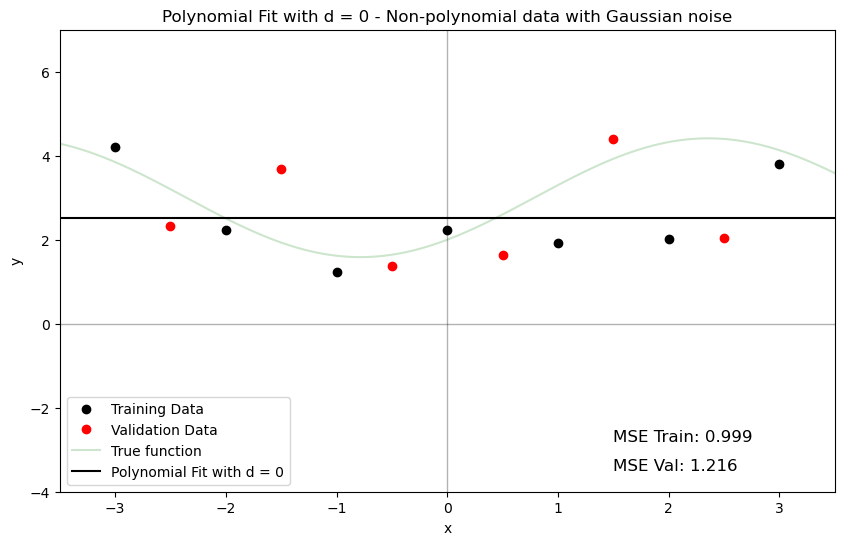

The polynomial is: 2.520224853 -0.03254416742 x 



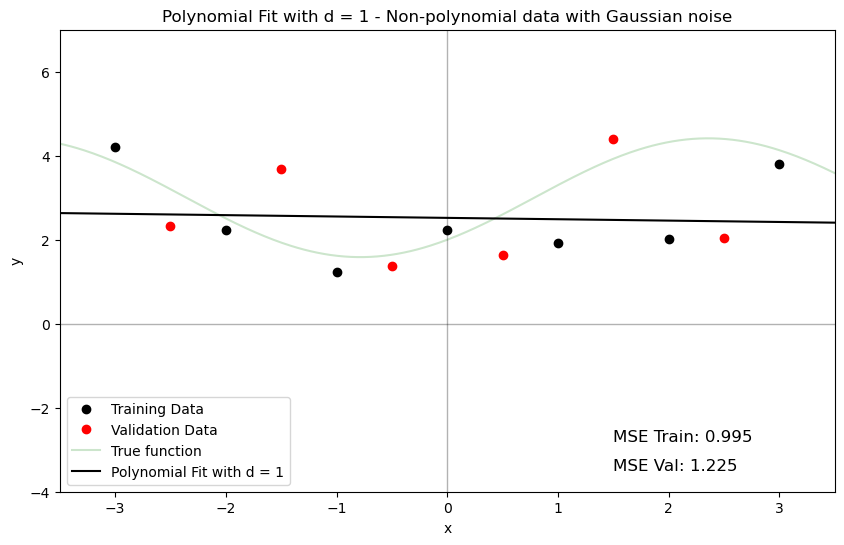

The polynomial is: 1.486000331 -0.03254416742 x +0.2585561304 x**2 



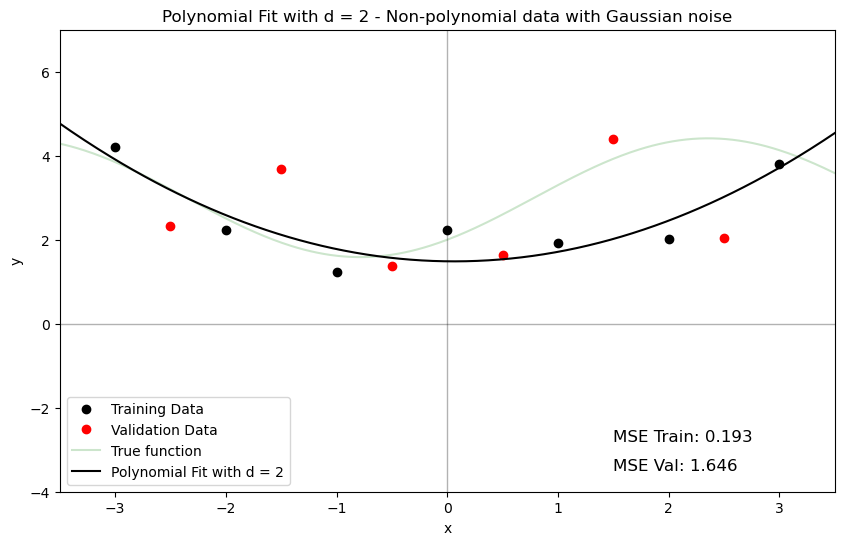

The polynomial is: 1.486000331 +0.1385917707 x +0.2585561304 x**2 -0.02444799116 x**3 



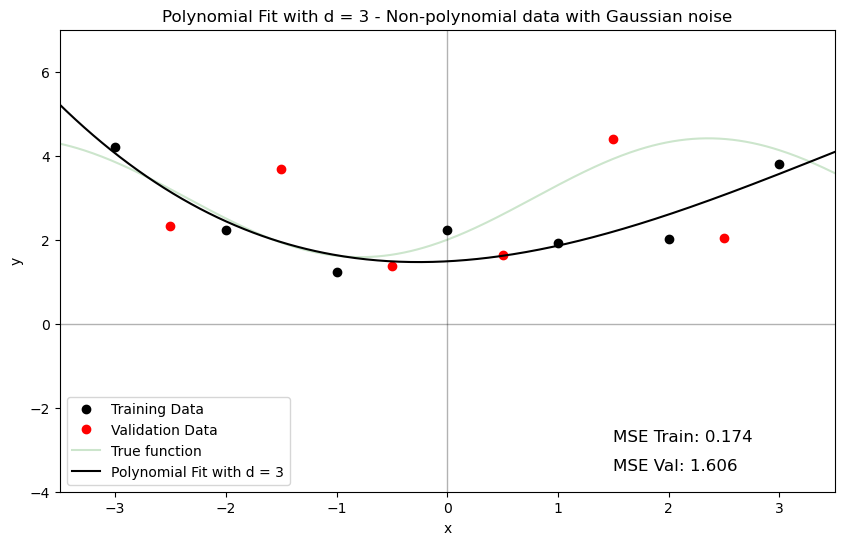

The polynomial is: 1.916117089 +0.1385917707 x -0.1416914082 x**2 -0.02444799116 x**3 +0.04181690702 x**4 



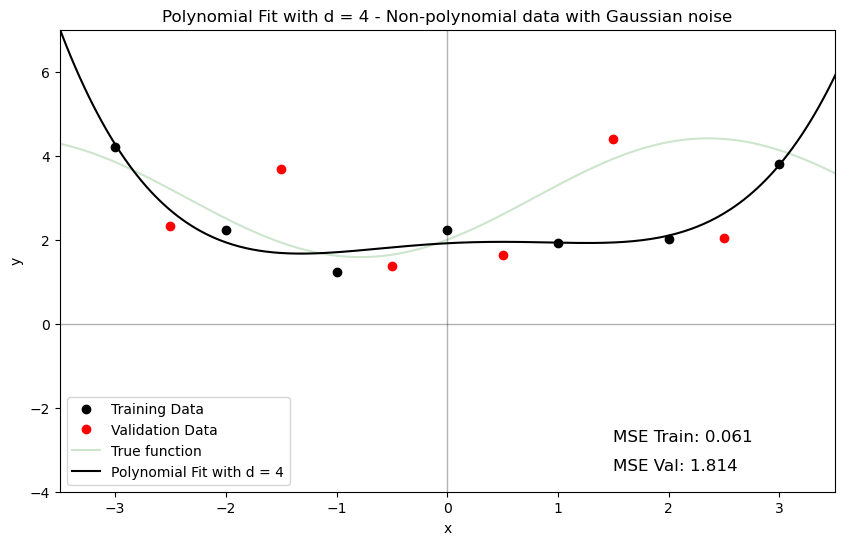

The polynomial is: 1.916117089 +0.5448219874 x -0.1416914082 x**2 -0.2143838749 x**3 +0.04181690702 x**4 +0.01628021861 x**5 



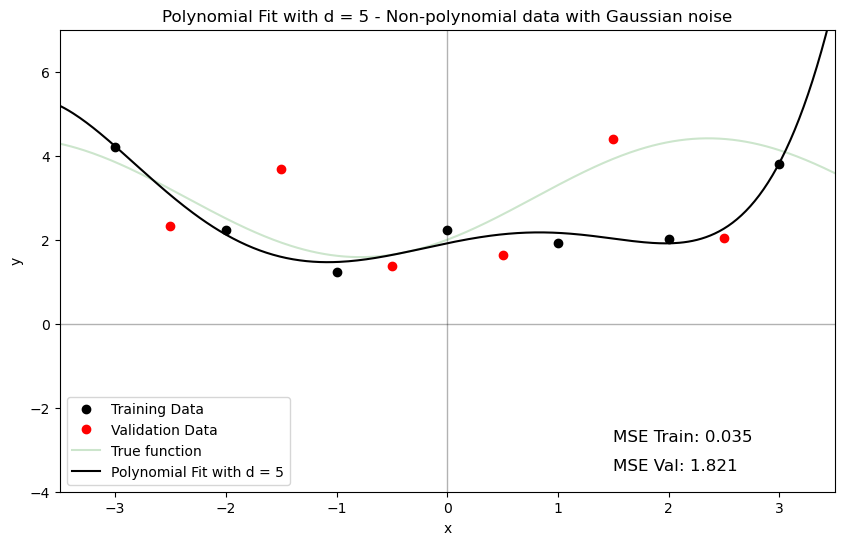

The polynomial is: 2.242937923 +0.5448219874 x -0.9690928177 x**2 -0.2143838749 x**3 +0.3182528618 x**4 +0.01628021861 x**5 -0.02097100347 x**6 



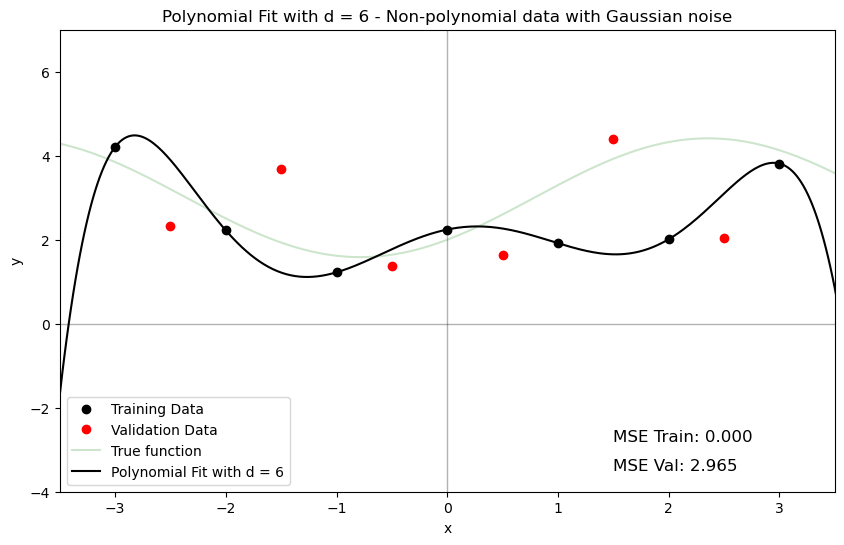

The polynomial is: 2.242937923 +0.2642704512 x -0.9690928177 x**2 +0.1674779383 x**3 +0.3182528618 x**4 -0.0928231566 x**5 -0.02097100347 x**6 +0.007793098229 x**7 



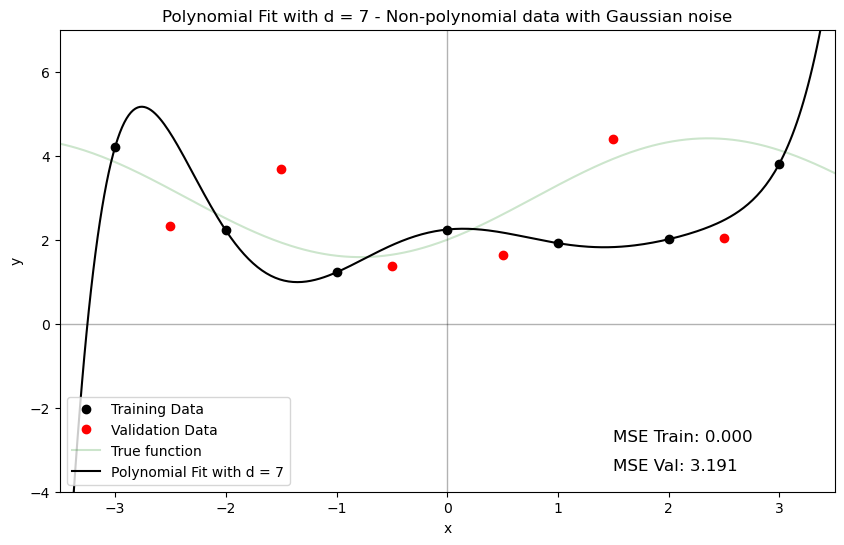

The polynomial is: 2.242937922 +0.2642704514 x -0.4996753222 x**2 +0.167477938 x**3 -0.3206765069 x**4 -0.09282315651 x**5 +0.1615802447 x**6 +0.007793098223 x**7 -0.01303937487 x**8 



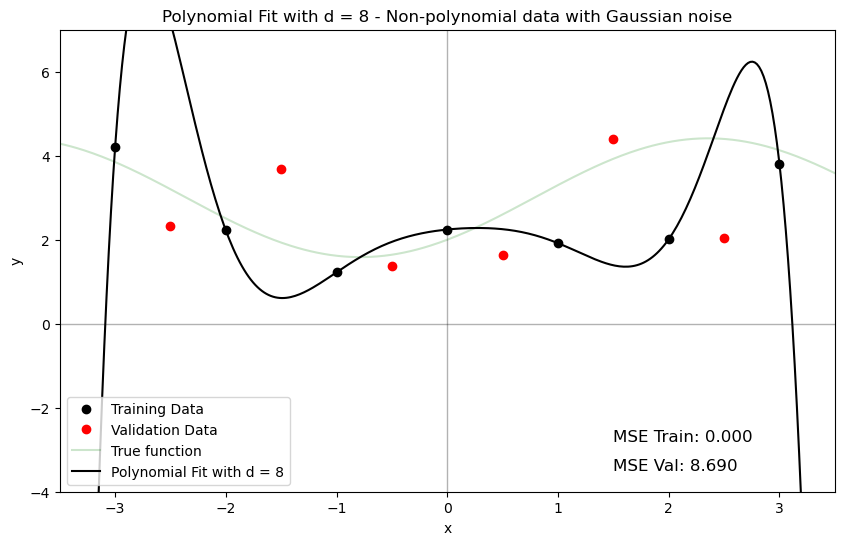

The polynomial is: 2.242937922 +0.1600079893 x -0.4996753222 x**2 +0.1446188071 x**3 -0.3206765068 x**4 +0.09090323145 x**5 +0.1615802447 x**6 -0.05338869407 x**7 -0.01303937487 x**8 +0.004576997987 x**9 



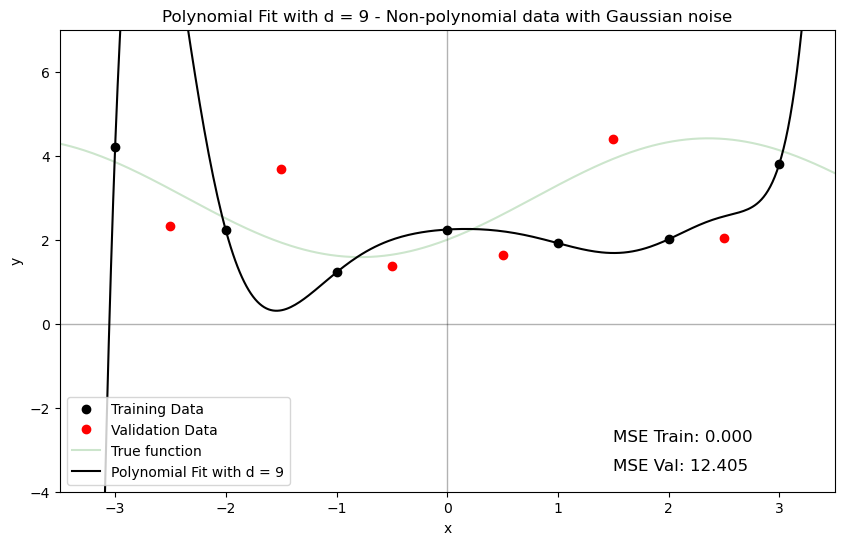

In [44]:
plot_polynomial_fits(x_train, y_train, x_val, y_val, polynomial_fits, solutions, "Non-polynomial data with Gaussian noise")

## Stochastic solution with non-polynomial fit (non-polynomial data)

In [45]:
def y(x: torch.Tensor) -> torch.Tensor:
    """Computes the function 3 + sin(x) - cos(x) for given x values.
    
    Args:
        x: A torch tensor of x values.
    
    Returns:
        A torch tensor of y values computed from the function.
    """
    return (3 + torch.sin(x) - torch.cos(x)).double()

def y_stat(x: torch.Tensor) -> torch.Tensor:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.

    Args:
        x: A torch tensor of x values.

    Returns:
        A torch tensor of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values = y(x)

    # Add Gaussian noise with mean 0 and standard deviation 1
    noisy_y_values = torch.normal(mean=true_y_values, std=1.0)

    return noisy_y_values

def y_stat_np(x: np.ndarray) -> np.ndarray:
    """Generates noisy polynomial data by adding Gaussian noise to the true y values.
    
    Args:
        x: A numpy array of x values.
    
    Returns:
        A numpy array of y values computed from the polynomial expression with added Gaussian noise.
    """
    # Generate true y values based on a polynomial expression
    true_y_values: np.ndarray = y(torch.tensor(x)).numpy()
    
    # Add Gaussian noise with a mean of 0 and standard deviation of 1 to the true y values
    noisy_y_values: np.ndarray = np.random.normal(true_y_values, 1)
    
    return noisy_y_values

def design_matrix_trig_torch(x_values: torch.Tensor) -> torch.Tensor:
    """Generates a design matrix for trigonometric regression with PyTorch.
    
    Args:
        x_values: A torch.Tensor of x values.
    
    Returns:
        A torch.Tensor representing the design matrix with columns for 1, sin(x), and cos(x).
    """
    ones = torch.ones_like(x_values)
    sin_x = torch.sin(x_values)
    cos_x = torch.cos(x_values)
    # Stack along the second dimension (axis=1) to form the design matrix
    return torch.stack([ones, sin_x, cos_x], dim=1)

def omega_solution(X: torch.Tensor, 
                   Y: torch.Tensor
                  ) -> torch.Tensor:
    """Calculates the polynomial coefficients (omega) that best fit the data.
    
    Args:
        X: The design matrix.
        Y: A torch tensor of target y values.
    
    Returns:
        A torch tensor of calculated omega values.
    """
    XT: torch.Tensor = X.t()  # Transpose of X
    Y: torch.Tensor = Y.view(-1, 1)  # Reshape Y to be a column vector
    omega: torch.Tensor = torch.linalg.pinv(XT @ X) @ XT @ Y
    return omega.view(-1)  # Flatten the omega tensor

def trig_solution(omega_solution: torch.Tensor, 
                  x_values: torch.Tensor
                 ) -> torch.Tensor:
    """Evaluates the trigonometric model at given x values using the omega coefficients.
    
    Args:
        omega_solution: A torch.Tensor of omega coefficients for [constant, sin(x), cos(x)].
        x_values: A torch.Tensor of x values for evaluation.
    
    Returns:
        A torch.Tensor of y values predicted by the trigonometric model.
    """
    return omega_solution[0] + omega_solution[1] * torch.sin(x_values) + omega_solution[2] * torch.cos(x_values)

def MSE(omega_solution: torch.Tensor, 
        x_values: torch.Tensor,
        y_true: torch.Tensor
       ) -> torch.Tensor:
    """Calculates the Mean Squared Error (MSE) for given omega coefficients and x values.
    
    Args:
        omega_solution: A 1D torch.Tensor of omega coefficients.
        x_values: A 1D torch.Tensor of x values for evaluation.
    
    Returns:
        The MSE as a torch.Tensor.
    """
    y_pred: torch.Tensor = trig_solution(omega_solution, x_values)
    return torch.mean((y_true - y_pred)**2)

In [46]:
# Generate data coordinates
x_train = torch.arange(-3, 4, 1, dtype=torch.float64)
x_val = torch.arange(-2.5, 3.5, 1, dtype=torch.float64)

# Generate target values through the statistical model with torch
torch.manual_seed(100)
y_train = y_stat(x_train)
y_val = y_stat(x_val)

# Flag to control printing of the solution details
show = True

# Generate the design matrix
X_train = design_matrix_trig_torch(x_train)

# Compute the weights of the solution
omega_hat = omega_solution(X_train, y_train)

# Compute the MSE for the training and validation data
MSE_train = MSE(omega_hat, x_train, y_train)
MSE_val = MSE(omega_hat, x_val, y_val)

# Print the results
if show:
    print("----------------- Trigonometric Model -----------------")
    print(f"The design matrix is:\n{X_train}\n")
    print(f"The target values are:\n{y_train}\n")
    print(f"The solution for omega is: {omega_hat}\n")
    print(f"The MSE for the training data is: {MSE_train}")
    print(f"The MSE for the validation data is: {MSE_val}\n")

----------------- Trigonometric Model -----------------
The design matrix is:
tensor([[ 1.0000, -0.1411, -0.9900],
        [ 1.0000, -0.9093, -0.4161],
        [ 1.0000, -0.8415,  0.5403],
        [ 1.0000,  0.0000,  1.0000],
        [ 1.0000,  0.8415,  0.5403],
        [ 1.0000,  0.9093, -0.4161],
        [ 1.0000,  0.1411, -0.9900]], dtype=torch.float64)

The target values are:
tensor([4.2095, 2.2209, 1.2244, 2.2429, 1.9178, 2.0120, 3.8139],
       dtype=torch.float64)

The solution for omega is: tensor([ 2.4128,  0.1086, -1.0278], dtype=torch.float64)

The MSE for the training data is: 0.4183487933903772
The MSE for the validation data is: 1.3736800844998454



In [47]:
# Generate data coordinates
x_train = torch.arange(-3, 4, 1, dtype=torch.float64)
x_val = torch.arange(-2.5, 3.5, 1, dtype=torch.float64)

# Set the random seed for reproducibility using NumPy
np.random.seed(100)

# Generate target values through the statistical model with NumPy (for consistency)
y_train = y_stat_np(x_train)
y_val = y_stat_np(x_val)

# Flag to control printing of the solution details
show = True

# Generate the design matrix (Torch)
X_train = design_matrix_trig_torch(x_train)

# Compute the weights of the solution
omega_hat = omega_solution(X_train, torch.tensor(y_train, dtype=torch.float64))

# Compute the MSE for the training and validation data
MSE_train = MSE(omega_hat, x_train, torch.tensor(y_train, dtype=torch.float64))
MSE_val = MSE(omega_hat, x_val, torch.tensor(y_val, dtype=torch.float64))

# Print the results
if show:
    print("----------------- Trigonometric Model -----------------")
    print(f"The design matrix is:\n{X_train}\n")
    print(f"The target values are:\n{y_train}\n")
    print(f"The solution for omega is: {omega_hat}\n")
    print(f"The MSE for the training data is: {MSE_train}")
    print(f"The MSE for the validation data is: {MSE_val}\n")

----------------- Trigonometric Model -----------------
The design matrix is:
tensor([[ 1.0000, -0.1411, -0.9900],
        [ 1.0000, -0.9093, -0.4161],
        [ 1.0000, -0.8415,  0.5403],
        [ 1.0000,  0.0000,  1.0000],
        [ 1.0000,  0.8415,  0.5403],
        [ 1.0000,  0.9093, -0.4161],
        [ 1.0000,  0.1411, -0.9900]], dtype=torch.float64)

The target values are:
[2.09910702 2.84952981 2.77126251 1.74756396 4.28248947 4.8396631
 4.35229217]

The solution for omega is: tensor([ 3.2327,  1.0931, -0.4274], dtype=torch.float64)

The MSE for the training data is: 0.6231208529025825
The MSE for the validation data is: 0.4426790841588118



/tmp/ipykernel_2756236/2030768385.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_y_values: np.ndarray = y(torch.tensor(x)).numpy()


Fit with true function



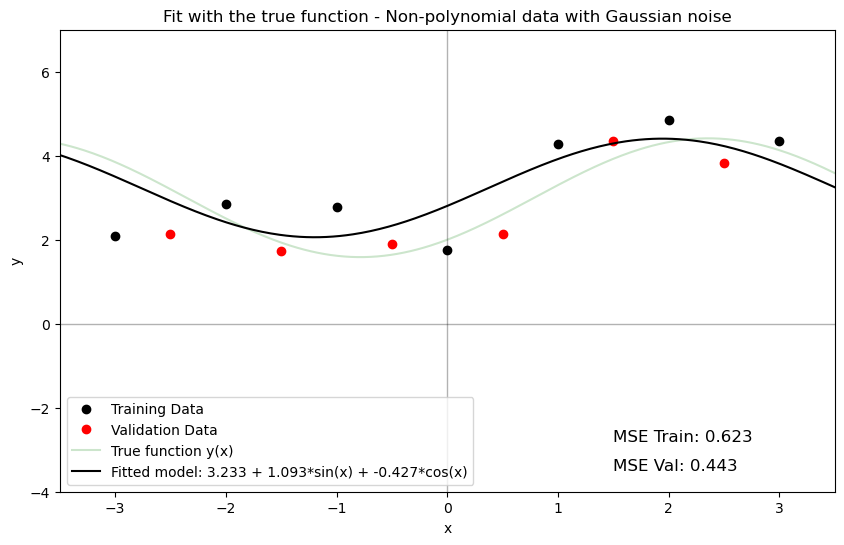

In [48]:
# Print the results
print("Fit with true function\n")
omega_hat_str = f"{omega_hat[0]:.3f} + {omega_hat[1]:.3f}*sin(x) + {omega_hat[2]:.3f}*cos(x)"

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x_train.numpy(), y_train, 'o', label='Training Data', color='black')
plt.plot(x_val.numpy(), y_val, 'o', label='Validation Data', color='red')

# Generate x values for plotting (to create a smooth curve for the plot)
x_values = torch.linspace(-4., 4., 400, dtype=torch.float64)

# Generate y values for the function and the fitted model
y_values_func = y(x_values)
y_values_fit = trig_solution(omega_hat, x_values)

# Plot the results
plt.text(1.5, -2.8, f'MSE Train: {MSE_train:.3f}', fontsize=12, color='black')
plt.text(1.5, -3.5, f'MSE Val: {MSE_val:.3f}', fontsize=12, color='black')
plt.plot(x_values.numpy(), y_values_func.numpy(), label='True function y(x)', color='green', alpha=0.2)
plt.plot(x_values.numpy(), y_values_fit.numpy(), label=f'Fitted model: {omega_hat_str}', color='black')

# Drawing axes
plt.axhline(y=0, color='k', linestyle='-', linewidth=1, alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', linewidth=1, alpha=0.3)

# Finalizing plot
plt.title('Fit with the true function - Non-polynomial data with Gaussian noise')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower left')
plt.xlim(-3.5, 3.5)
plt.ylim(-4, 7)
plt.show()